In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import to_rgb
from matplotlib import gridspec
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'

from scipy.integrate import cumtrapz

In [2]:
xr.set_options(display_style = 'text')

In [5]:
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.298K.3km/')
test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')

test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/')

test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/')

test = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')

test = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')


# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=70): #default extracts 700 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfsub(simulation_path,nfiles=70): #default extracts 700 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*subset.nc'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [6]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

In [7]:
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')

In [8]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [9]:
hrchannel500_11 = extract_wrfsub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.11mps.3km/')
hrchannel500_11_ini = xr.open_dataset('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.11mps.3km/wrfout_d01_1970-01-01_00_00_00_initialtime.nc')

In [10]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [11]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [12]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None,dsinput=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    if dsinput is None:
        dsinput=ds
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(dsinput.PB[0,:,0]+ds.P[-100:].mean(['Time','south_north']))[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

def interp_eta_to_z(ds,var,staggered=1,zlevs=None,dsinput=None):
    """Make sure eta_level is the first dimension"""
    if zlevs is None:
        zlevs= np.arange(0.,16000.,200.)
    if dsinput is None:
        dsinput=ds
    rep = np.zeros((len(zlevs),len(var[0])))
    PHB = np.array(dsinput.PHB[0,:,0]+ds.PH[-100:].mean(['Time','south_north']))/9.81
    var_ar=np.array(var)
    if not staggered:
        ZNW_rev = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])
        for i in range(len(var[0])):
            PHB_unstag = np.interp(ZNU,ZNW_rev,PHB[::-1,i])
            rep[:,i]=np.interp(zlevs,PHB_unstag,var_ar[:,i],left=np.nan,right=np.nan)
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(zlevs,PHB[:,i],var_ar[:,i],left=np.nan,right=np.nan)
    return xr.DataArray(rep,coords={'z':zlevs,'distance_from_mtn':var.distance_from_mtn},dims=['z','distance_from_mtn'])

In [13]:
import wrf
from netCDF4 import Dataset
def interp_pressure(var):
    """var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

In [14]:
from scipy.interpolate import interp1d
def interp_pressure2(ds,var,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4][::-1]/100
    rep=np.zeros((len(var.Time),len(plevs),len(var.south_north),len(var.west_east)))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[:,::-1]
    for k in range(len(var.west_east)):
        rep[:,:,:,k]=interp1d(PB_rev[:,k], var_rev[:,:,:,k], kind='linear', axis=1,fill_value='extrapolate', assume_sorted=True)(plevs*100)

    return xr.DataArray(rep[:,::-1],coords={'Time':var.Time,'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['Time','pressure','south_north','west_east'])

In [15]:
def linear_w_N(xx,hx,U,N,vert_coord='z'):
    top=15e3
    Nz=100
    
    z=np.linspace(0,top,Nz)
    k=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    if vert_coord=='z':
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])
    elif vert_coord=='p':
        p = 1000*np.exp(-9.81/287.*cumtrapz(1/(300-6.5e-3*z),z,initial=0.))
        w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'pressure':p},dims=['distance_from_mtn','pressure'])
    return w

def linear_u_N(xx,hx,U,N,vert_coord='z'):
    top=15e3
    Nz=100
    
    z=np.linspace(0,top,Nz)
    k=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    
    u_hat = -U*h_hat[:,None]*m_exponent(k[:,None],N,U)  *np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    if vert_coord=='z':
        u=xr.DataArray(np.real(np.fft.ifft(u_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude'])
    elif vert_coord=='p':
        p = 1000*np.exp(-9.81/287.*cumtrapz(1/(300-6.5e-3*z),z,initial=0.))
        u=xr.DataArray(np.real(np.fft.ifft(u_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'pressure':p},dims=['distance_from_mtn','pressure'])
    return u

## Extra data & functions

In [32]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

rhomean = rhomean.where(rhomean >0.)  
wmean   = wmean.where(wmean > -10)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
wmean_p =     change_coords_pl(hrchannel_p,wmean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [17]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
umean = umean.where(umean >-30.)  
umean_p = change_coords_pl(hrchannel_p,umean)[1:-4]

vmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days160-200.nc')
vmean = vmean.where(vmean >-30.)  
vmean_p = change_coords_pl(hrchannel_p,vmean)[1:-4]

In [39]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [16]:
lmumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.U_PL.days50-200.nc')
lmumean   = lmumean.where(lmumean >-30.)  
lmumean_p = change_coords_pl(lmchannel_p,lmumean)[1:-4]

lmvmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.V_PL.days50-200.nc')
lmvmean   = lmvmean.where(lmvmean >-30.)  
lmvmean_p = change_coords_pl(lmchannel_p,lmvmean)[:-1]

In [ ]:
#%time vpl = hrchannel_p.V_PL[-960:].mean(['Time','south_north']).load()
#vpl.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days160-200.nc')

# Barrier jet & blocking

## Profiles of V

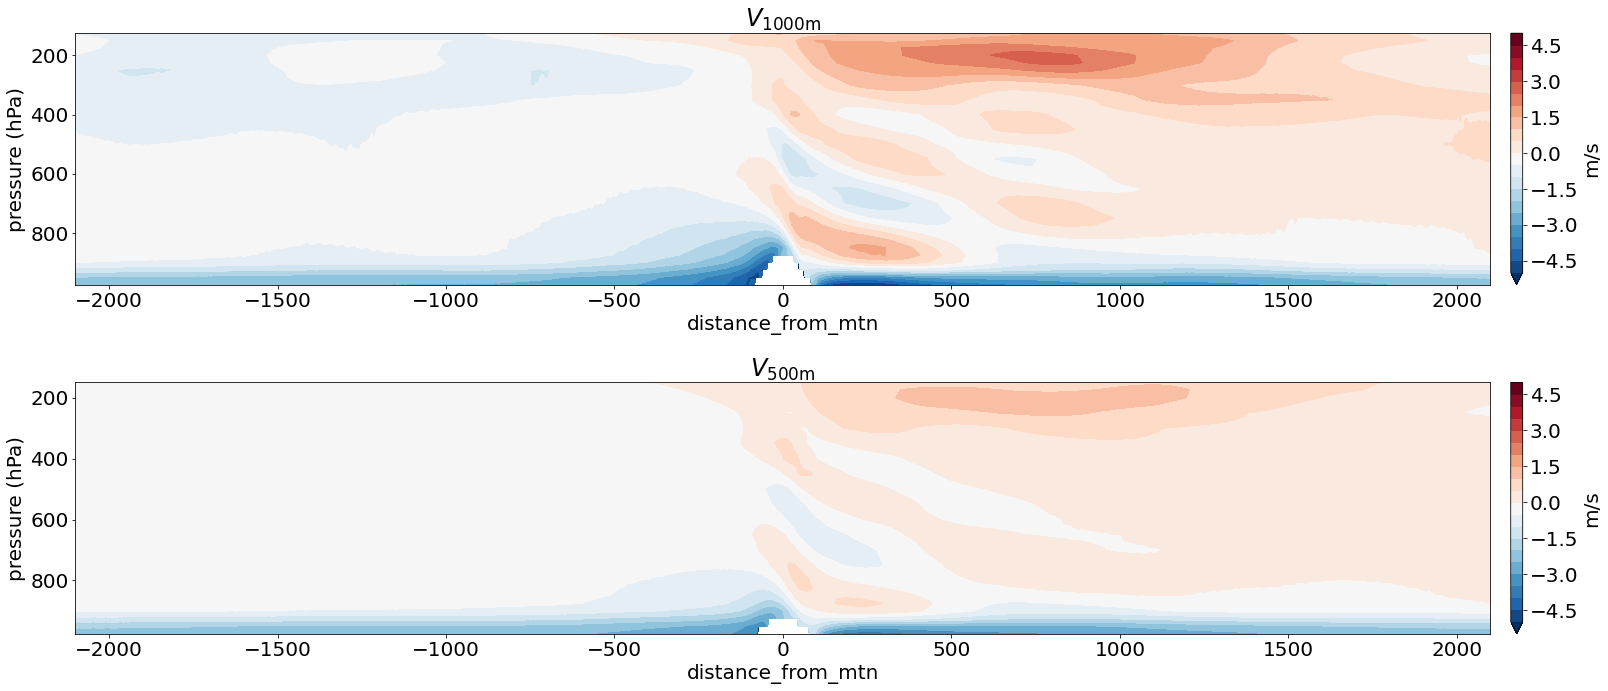

In [81]:
matplotlib.rcParams.update({'font.size': 20})
fig,axs=plt.subplots(2,1,figsize=(25,10))

vlevs = np.arange(-5.,5.1,0.5)
vmean_p.plot.contourf(  ax=axs[0],yincrease=False,levels=vlevs,cbar_kwargs={'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)
lmvmean_p.plot.contourf(ax=axs[1],yincrease=False,levels=vlevs,cbar_kwargs={'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)

for ax in axs:
    ax.set_ylabel("pressure (hPa)")
    ax.set_xlim(-2100,2100)
axs[0].set_title(r"$V_{\mathrm{1000m}}$")
axs[1].set_title(r"$V_{\mathrm{500m}}$")
fig.tight_layout()

Text(0.5, 0, 'Distance west of mountain top (km)')

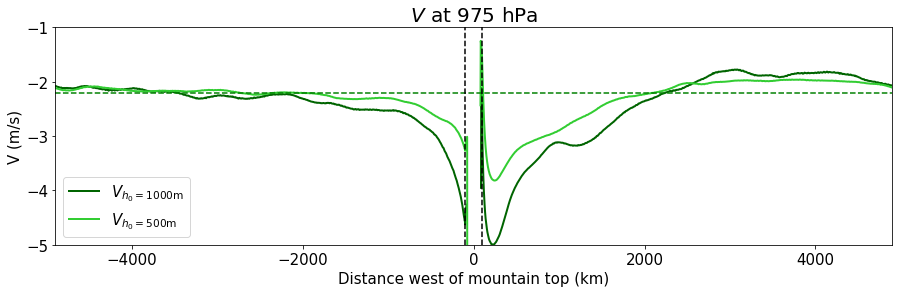

In [25]:
matplotlib.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(1,1,figsize=(15,4))

vmean_p[0].plot(  ax=ax,label = r"$V_{h_0=\mathrm{1000m}}$",linewidth=2,color='darkgreen')
lmvmean_p[0].plot(ax=ax,label = r"$V_{h_0=\mathrm{500m}}$" ,linewidth=2,color='limegreen')

ax.set_ylabel("V (m/s)")
ax.set_xlim(-4900,4900)
ax.set_ylim(-5.,-1.)
ax.axhline(-2.2,color='g',linestyle='--')
ax.legend()
ax.set_title(r"$V$ at 975 hPa",fontsize=20.)
ax.axvline(-100.,color='k',linestyle='--')
ax.axvline(100.,color='k',linestyle='--')
ax.set_xlabel("Distance west of mountain top (km)")

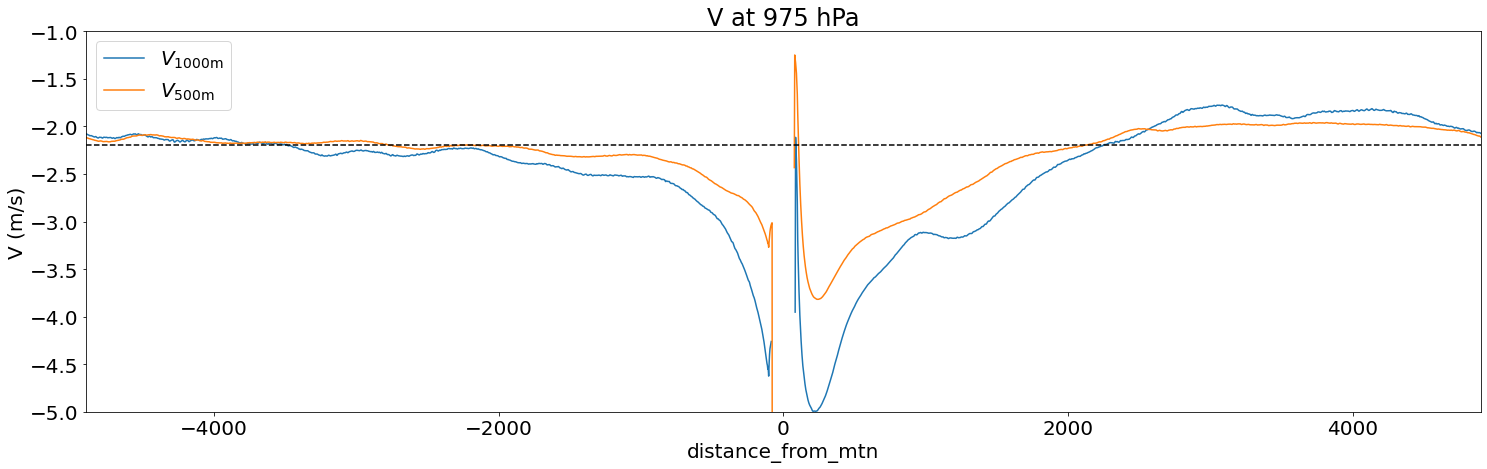

In [82]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

vmean_p[0].plot(     ax=ax,label = r"$V_{\mathrm{1000m}}$")
lmvmean_p[0].plot(ax=ax,label = r"$V_{\mathrm{500m}}$" )

ax.set_title("V at 975 hPa")
ax.set_ylabel("V (m/s)")
ax.set_xlim(-4900,4900)
ax.set_ylim(-5.,-1.)
ax.axhline(-2.2,color='k',linestyle='--')
ax.legend()

Text(0.5, 1.0, "$V'_{\\mathrm{1000m}} - 2\\times V_{\\mathrm{500m}}$")

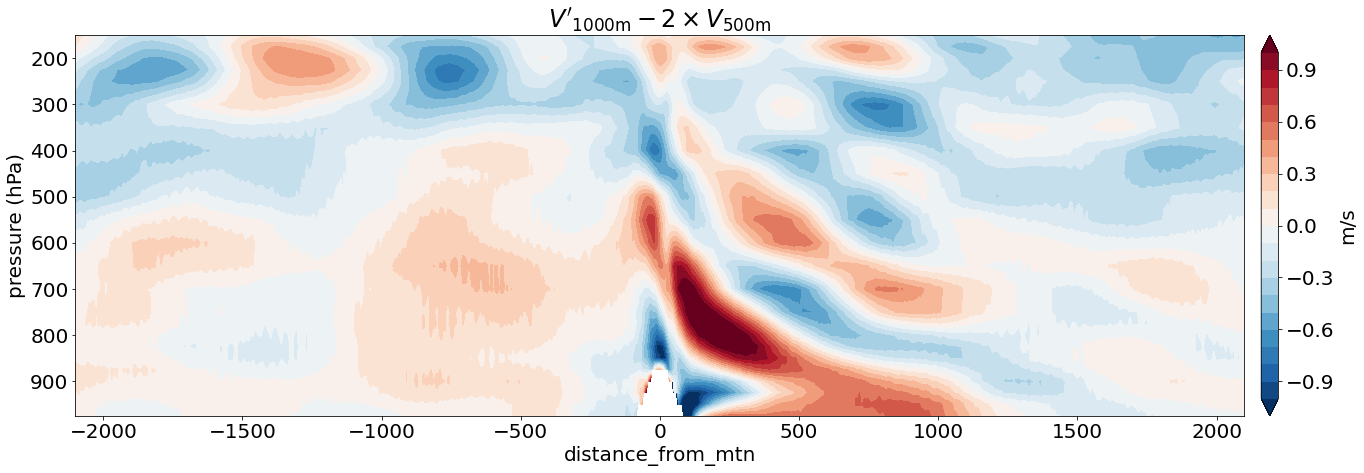

In [78]:
matplotlib.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(1,1,figsize=(25,7))

vpl2_ups     =vpl2[:,2500:3000].mean('distance_from_mtn')
lmvmean_p_ups=lmvmean_p[:,2500:3000].mean('distance_from_mtn')

vlevs = np.arange(-1.,1.1,0.1)
(vpl2-vpl2_ups-2*(lmvmean_p-lmvmean_p_ups)).plot.contourf(  ax=ax,yincrease=False,levels=vlevs,cbar_kwargs={'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)
lmvmean_p.plot.contourf(ax=axs[1],yincrease=False,levels=vlevs,cbar_kwargs={'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)

ax.set_ylabel("pressure (hPa)")
ax.set_xlim(-2100,2100)
ax.set_title(r"$V'_{\mathrm{1000m}} - 2\times V_{\mathrm{500m}}$")


## Surface pressure - geopotential height

In [16]:
psfc = change_coords_sfc(hrchannel.PSFC[-400:].mean(['Time','south_north']).load())

In [33]:
%time psfc_500_11 = change_coords_sfc(extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/').PSFC[-400:].mean(['Time','south_north']).load())


CPU times: user 7.02 s, sys: 7.29 s, total: 14.3 s
Wall time: 20.4 s


In [39]:
def extract_wrfout_sub(simulation_path):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*subset.nc'))
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
%time psfc_500_9 = change_coords_sfc(extract_wrfout_sub('/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.500m.9mps.3km/').PSFC[-400:].mean(['Time','south_north']).load())


CPU times: user 2.79 s, sys: 1.73 s, total: 4.52 s
Wall time: 25.3 s


In [30]:
xx,hx = topographic_profile('cos')
u_linear = linear_u_N(xx,hx,10,0.012,vert_coord='z')
psfc_linear = 997.5-1.2*10*u_linear[:,0]/100

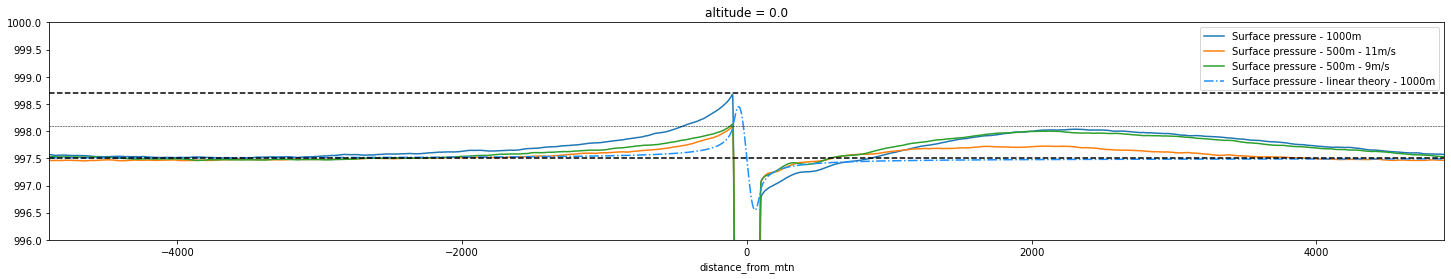

In [47]:
fig,ax=plt.subplots(1,1,figsize=(25,4))

(psfc/100).plot( ax=ax,label = r"Surface pressure - 1000m")
(psfc_500_11/100+0.5).plot( ax=ax,label = r"Surface pressure - 500m - 11m/s")
(psfc_500_9/100+0.75).plot( ax=ax,label = r"Surface pressure - 500m - 9m/s")
psfc_linear.plot( ax=ax,label = r"Surface pressure - linear theory - 1000m",color='dodgerblue',linestyle='-.')
ax.set_ylim(996,1000)
ax.axhline(997.5,color='k',linestyle='--')
ax.axhline(998.1,color='k',linestyle='--',linewidth=0.5)
ax.axhline(998.7,color='k',linestyle='--')
ax.set_xlim(-4900,4900)
ax.legend()

## Potential temperature contours

In [35]:
%time thetamean_s = change_coords_eta(hrchannel,300+hrchannel.T[-400:].mean(['Time','south_north']).load())
thetamean_sp  = interp_eta_to_pressure(hrchannel,thetamean_s,staggered=0,plevs=np.array(list(np.arange(125.,870.,20.))+list(np.arange(870.,985.,5.))+list(np.arange(985.,998.,2.))))


CPU times: user 16.5 s, sys: 29.6 s, total: 46.1 s
Wall time: 44.3 s


In [78]:
%time lm11thetamean_s = change_coords_eta(hrchannel500_11,300+hrchannel500_11.T[-400:].mean(['Time','south_north']).load())
lm11thetamean_sp  = interp_eta_to_pressure(hrchannel500_11,lm11thetamean_s,staggered=0,plevs=np.array(list(np.arange(125.,870.,20.))+list(np.arange(870.,985.,5.))+list(np.arange(985.,998.,2.))))


CPU times: user 15.9 s, sys: 1min 4s, total: 1min 20s
Wall time: 57.5 s


Text(0.5, 1.0, 'Potential temperature contours, 1000m mountain')

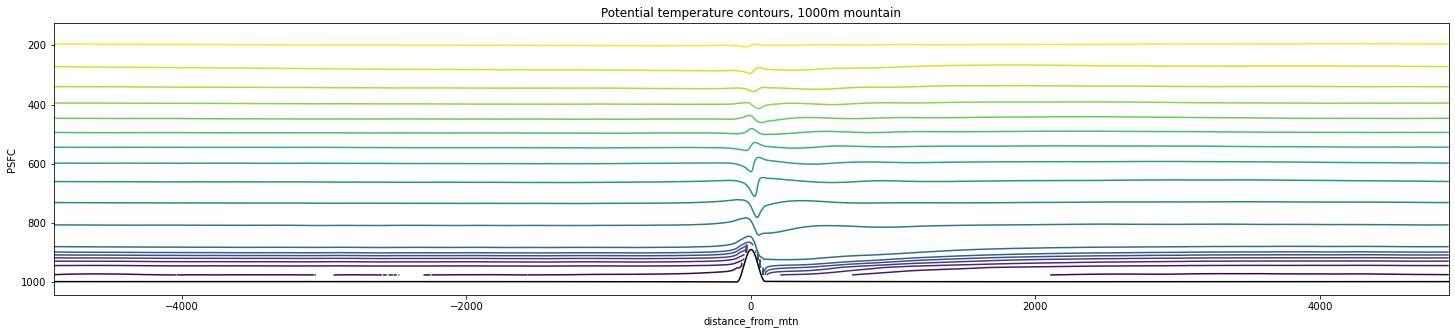

In [63]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
thetamean_p = tmean_p*(tmean_p.pressure/1e3)**(-0.286)
thetamean_p.plot.contour(ax=ax,yincrease=False,levels=list(np.arange(299.5,302.5,0.5))+list(np.arange(303,350,4)))
(psfc/100).plot(ax=ax,color='k')
ax.set_title('Potential temperature contours, 1000m mountain')

Text(0.5, 1.0, 'Potential temperature contours, 1000m mountain')

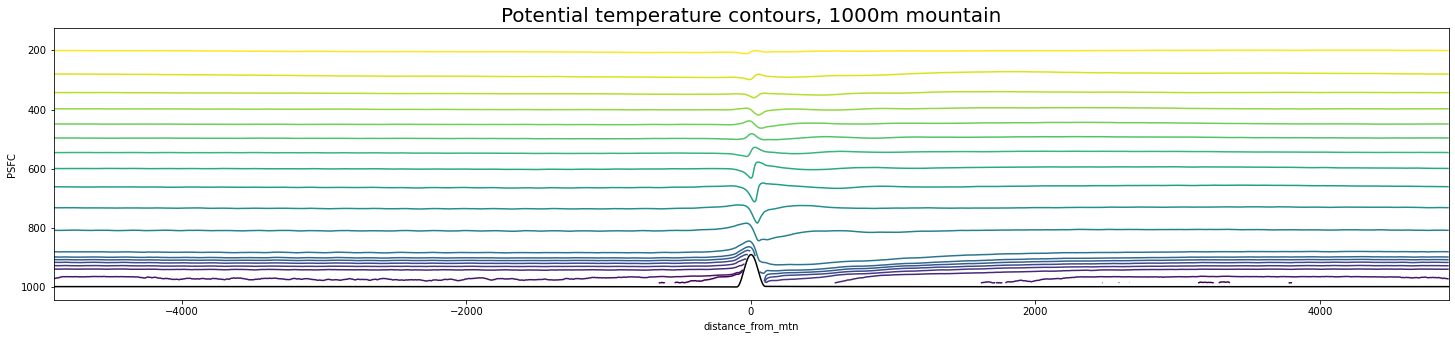

In [95]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
thetamean_sp.plot.contour(ax=ax,yincrease=False,levels=[299.4]+list(np.arange(299.5,302.5,0.5))+list(np.arange(303,350,4)))
(psfc/100).plot(ax=ax,color='k')
ax.set_title('Potential temperature contours, 1000m mountain',fontsize=20)

Text(0.5, 1.0, 'Potential temperature contours, 500m mountain')

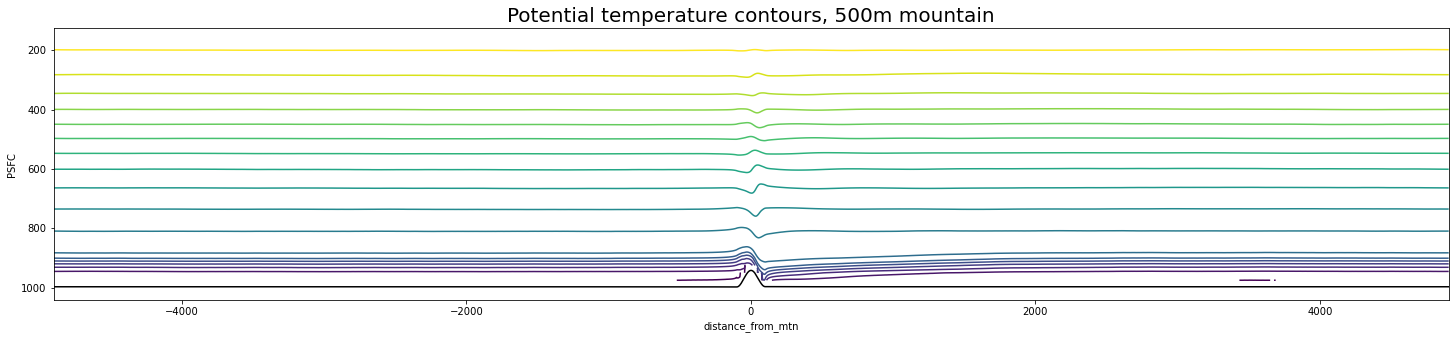

In [81]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
lmthetamean_p = lmtmean_p*(lmtmean_p.pressure/1e3)**(-0.286)
lmthetamean_p.plot.contour(ax=ax,yincrease=False,levels=list(np.arange(299.5,302.5,0.5))+list(np.arange(303,350,4)))
(psfc_500_11/100).plot(ax=ax,color='k')
ax.set_title('Potential temperature contours, 500m mountain',fontsize=20)

Text(0.5, 1.0, 'Potential temperature contours, 500m mountain, 11m/s, better resolution')

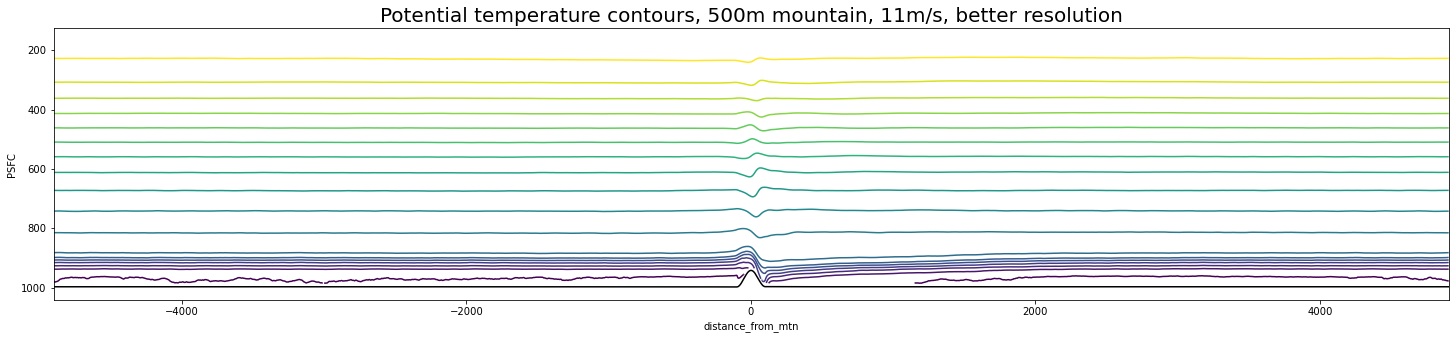

In [96]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
lm11thetamean_sp.plot.contour(ax=ax,yincrease=False,levels=list(np.arange(299.5,302.5,0.5))+list(np.arange(303,350,4)))
(psfc_500_11/100).plot(ax=ax,color='k')
ax.set_title('Potential temperature contours, 500m mountain, 11m/s, better resolution',fontsize=20)

## U,W in simulation vs linear theory

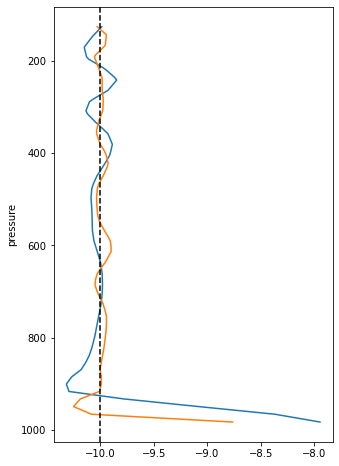

In [144]:
fig,ax=plt.subplots(1,1,figsize=(5,8))
umean_sp.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False)
udrymean_sp.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False)
ax.axvline(-10.,color='k',linestyle='--')

In [29]:
xx,hx = topographic_profile('cos')
w_linear_p = linear_w_N(xx,hx,10,0.012,vert_coord='p')
u_linear_p = linear_u_N(xx,hx,10,0.012,vert_coord='p')

In [30]:
wmean_s   = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wmean_sp  = interp_eta_to_pressure(hrchannel,wmean_s,staggered=1,plevs=np.array(w_linear_p.pressure[::-1]))
umean_s   = change_coords_eta(hrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc'),1,meta=True),staggered=False)
umean_sp  = interp_eta_to_pressure(hrchannel,umean_s,staggered=0,plevs=np.array(w_linear_p.pressure[::-1]))


In [31]:
wdrymean_s   = change_coords_eta(dryhrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)
wdrymean_sp  = interp_eta_to_pressure(dryhrchannel,wdrymean_s,staggered=1,plevs=np.array(w_linear_p.pressure[::-1]))


In [128]:
udrymean_s   = change_coords_eta(dryhrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U.days50-100.nc'),1,meta=True),staggered=False)
udrymean_sp  = interp_eta_to_pressure(dryhrchannel,udrymean_s,staggered=0,plevs=np.array(u_linear_p.pressure[::-1]))


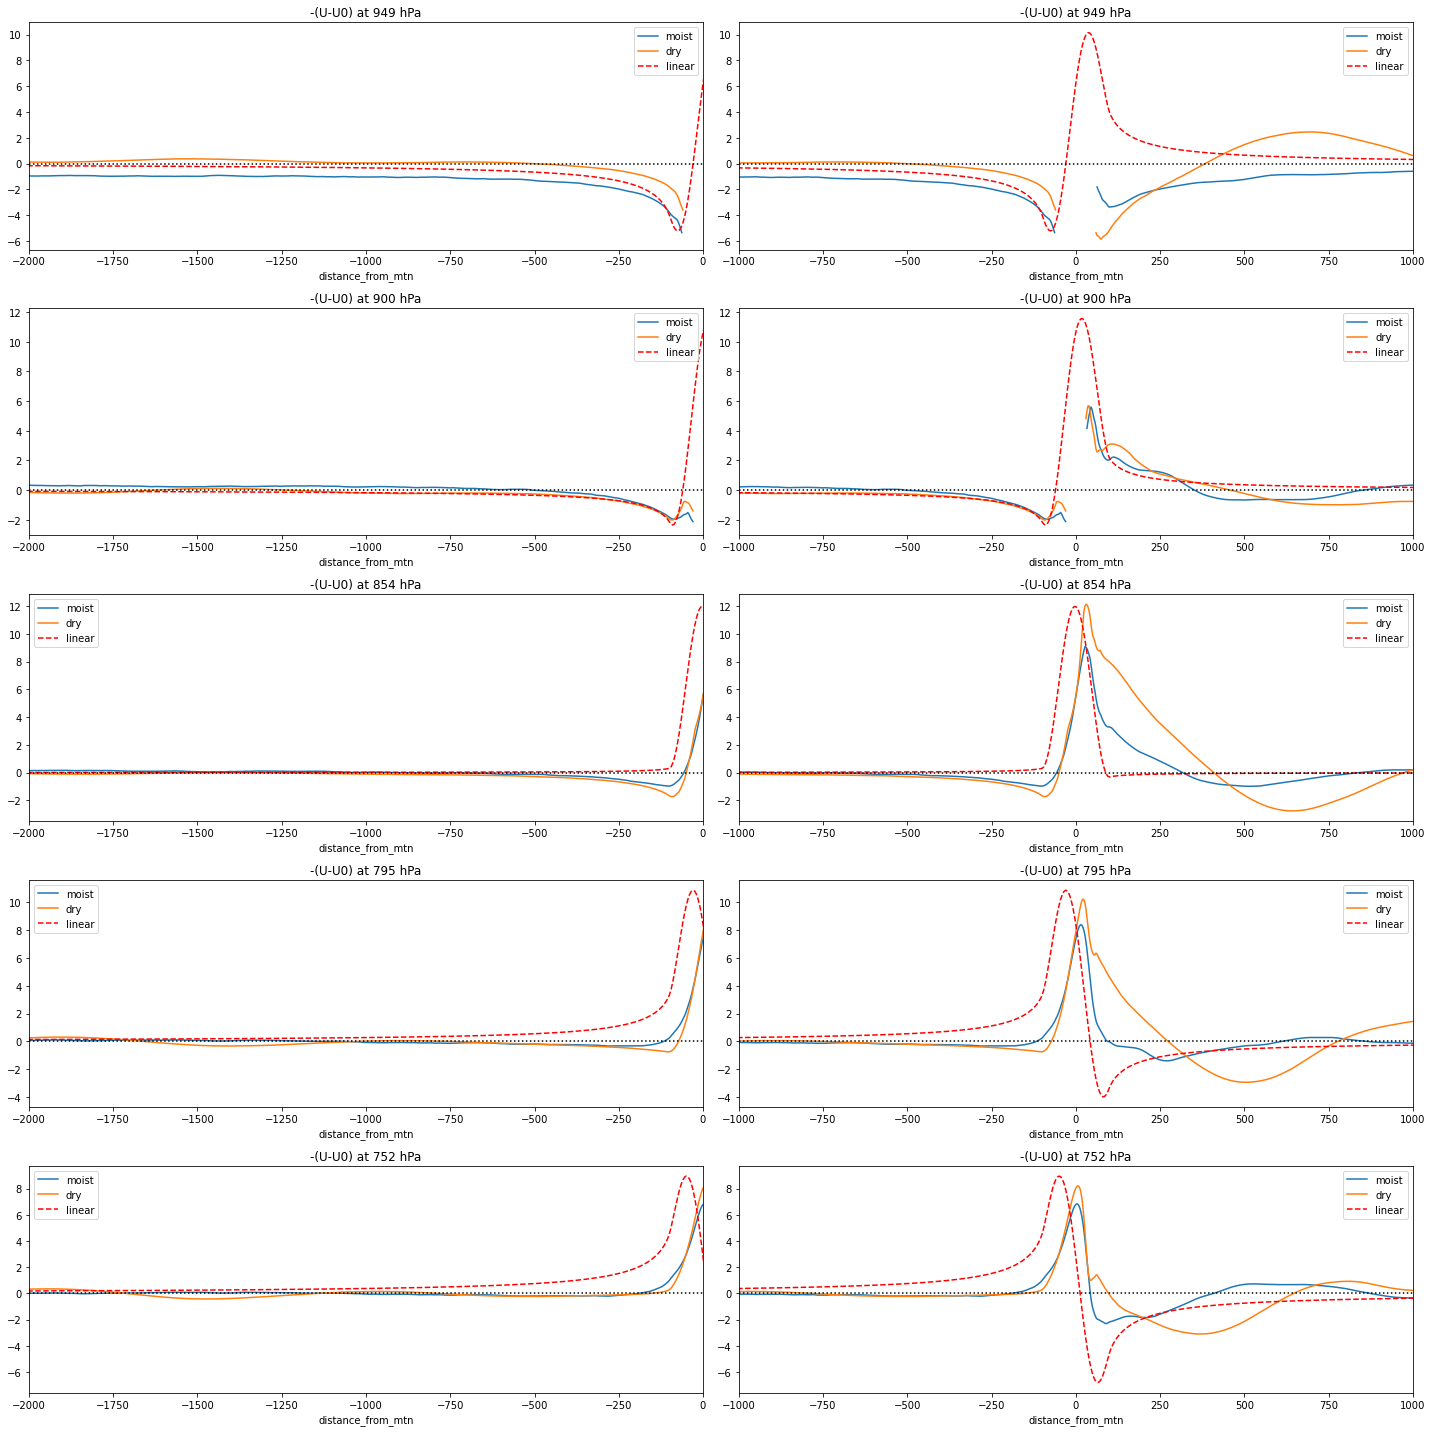

In [136]:
ps =[950,900,850,800,750]
n=len(ps)
fig,ax=plt.subplots(n,2,figsize=(20,4*n))
for i,p in enumerate(ps):
    for j in range(2):
        (-umean_sp-10).sel(pressure=p,method='nearest').plot(ax=ax[i,j],label='moist')
        (-udrymean_sp-10).sel(pressure=p,method='nearest').plot(ax=ax[i,j],label='dry')
        u_linear_p.sel(pressure=p,method='nearest').plot(ax=ax[i,j],color='r',linestyle='--',label='linear')
        ax[i,j].set_title("-(U-U0) at %i hPa"%(wmean_sp.pressure.sel(pressure=p,method='nearest')))
        ax[i,j].legend()
        ax[i,j].axhline(0.,color='k',linestyle=':')
    ax[i,0].set_xlim(-2000,0)
    #ax[i,0].set_ylim(-0.01,0.01)
    ax[i,1].set_xlim(-1000,1000)
    #ax[i,1].set_ylim(-0.3,0.15)
fig.tight_layout()

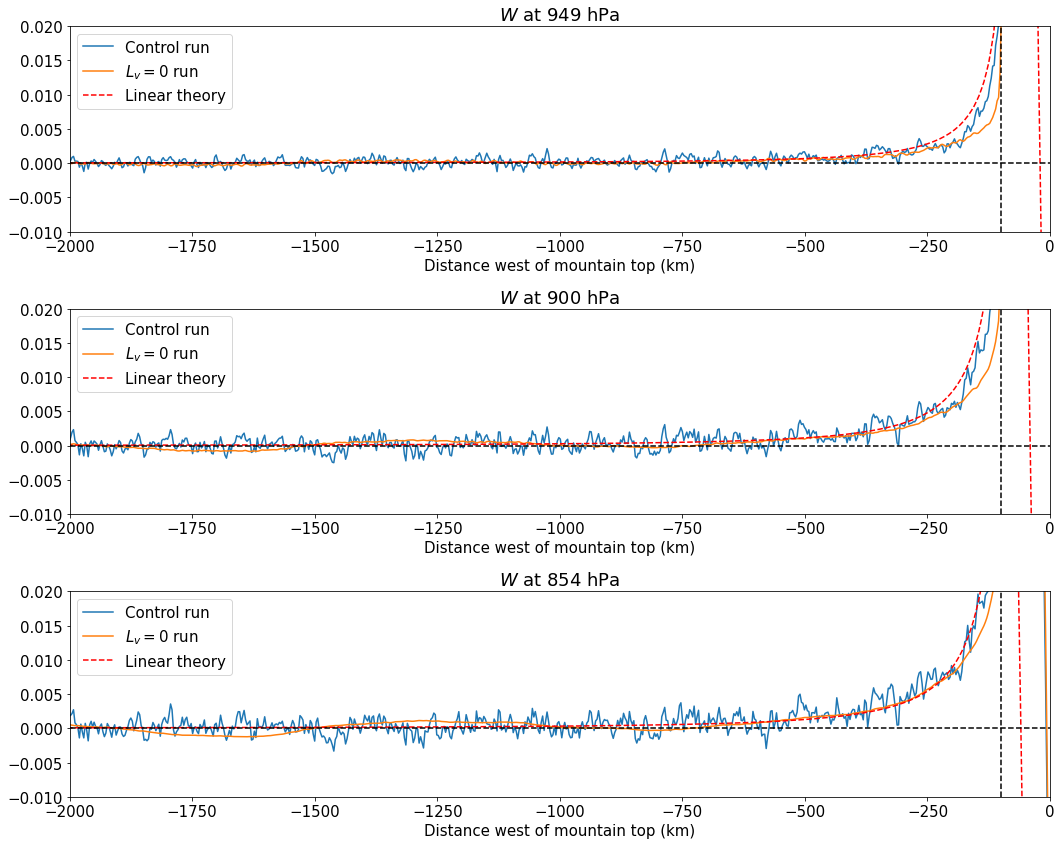

In [38]:
matplotlib.rcParams.update({'font.size': 15})
ps =[950,900,850]
n=len(ps)
fig,axs=plt.subplots(n,1,figsize=(15,4*n))
for i,(p,ax) in enumerate(zip(ps,axs)):
    wmean_sp.sel(pressure=p,method='nearest').plot(ax=ax,label='Control run')
    wdrymean_sp.sel(pressure=p,method='nearest').plot(ax=ax,label=r'$L_v=0$ run')
    w_linear_p.sel(pressure=p,method='nearest').plot(ax=ax,color='r',linestyle='--',label='Linear theory')
    ax.set_title(r"$W$ at %i hPa"%(wmean_sp.pressure.sel(pressure=p,method='nearest')))
    ax.axhline(0.,color='k',linestyle='--')
    ax.set_xlim(-2000,0)
    ax.set_ylim(-0.01,0.02)
    ax.axvline(-100.,color='k',linestyle='--')
    ax.set_xlabel("Distance west of mountain top (km)")
    ax.legend()
fig.tight_layout()

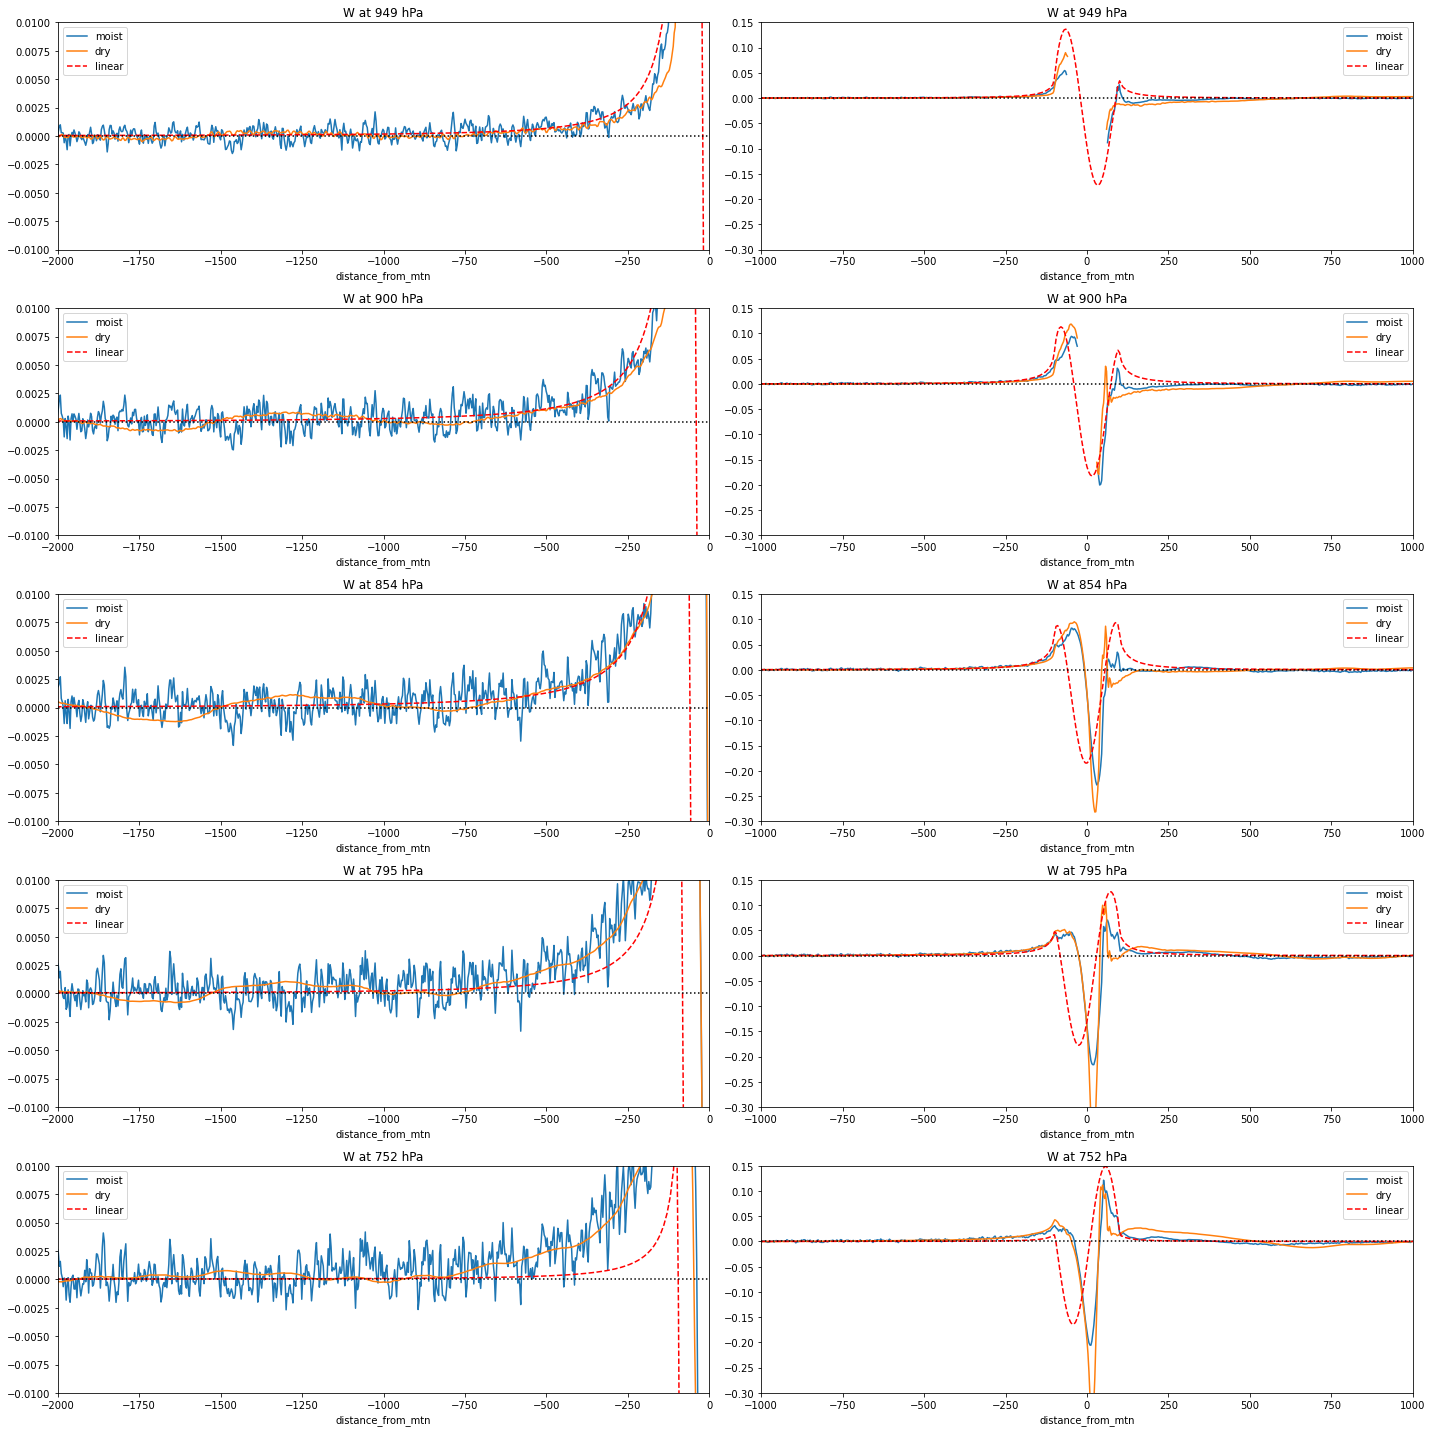

In [126]:
ps =[950,900,850,800,750]
n=len(ps)
fig,ax=plt.subplots(n,2,figsize=(20,4*n))
for i,p in enumerate(ps):
    for j in range(2):
        wmean_sp.sel(pressure=p,method='nearest').plot(ax=ax[i,j],label='moist')
        wdrymean_sp.sel(pressure=p,method='nearest').plot(ax=ax[i,j],label='dry')
        w_linear_p.sel(pressure=p,method='nearest').plot(ax=ax[i,j],color='r',linestyle='--',label='linear')
        ax[i,j].set_title("W at %i hPa"%(wmean_sp.pressure.sel(pressure=p,method='nearest')))
        ax[i,j].legend()
        ax[i,j].axhline(0.,color='k',linestyle=':')
    ax[i,0].set_xlim(-2000,0)
    ax[i,0].set_ylim(-0.01,0.01)
    ax[i,1].set_xlim(-1000,1000)
    ax[i,1].set_ylim(-0.3,0.15)
fig.tight_layout()

# Influence of mountain on N and dq/dz; vertical profiles

## N

In [33]:
def compute_N(T,pfactor,pname='pressure'):
    """T in K, p in Pa and N in s"""
    g = 9.81; R=287.
    rho = pfactor*T[pname]/R/T
    theta = T*(pfactor*T[pname]/1e5)**(-0.286)
    return np.sqrt(-rho*g*g/theta*theta.differentiate(pname)/pfactor)

In [36]:
g=9.81
tmean_sp = thetamean_sp*(thetamean_sp.pressure/1000)**0.286
rhomean_sp = 100*thetamean_sp.pressure/297./tmean_sp
hrN_bis = np.sqrt(-rhomean_sp*g*g/thetamean_sp*thetamean_sp.differentiate('pressure')/100)

In [40]:
hrN=compute_N(tmean_p,100)
lmN=compute_N(lmtmean_p,100)

Text(0.5, 1.0, 'Buoyancy frequency N (s$^{-1}$)')

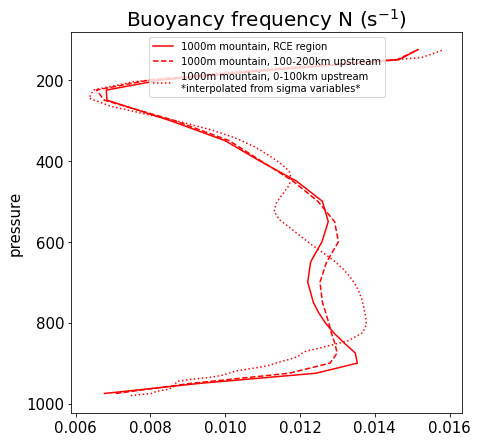

In [229]:
matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=(7,7))
hrN.sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,color='r',label='1000m mountain, RCE region')
hrN.sel(distance_from_mtn=slice(-100,-200)  ).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,color='r',label='1000m mountain, 100-200km upstream',linestyle='--')
hrN_bis.sel(distance_from_mtn=slice(0,-100)     ).mean('distance_from_mtn').plot(ax=ax,y='pressure',yincrease=False,color='r',label='1000m mountain, 0-100km upstream \n*interpolated from sigma variables*',linestyle=':')
ax.legend(fontsize=10)
ax.set_title(r"Buoyancy frequency N (s$^{-1}$)",fontsize=20.)


In [48]:
def pressure_avg(ds,p1,p2):
    pressures = ds.pressure.sel(pressure=slice(p1,p2))
    return ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(pressures[-1]-pressures[0])

Text(0.5, 1.0, 'N averaged between 870 and 700 hPa')

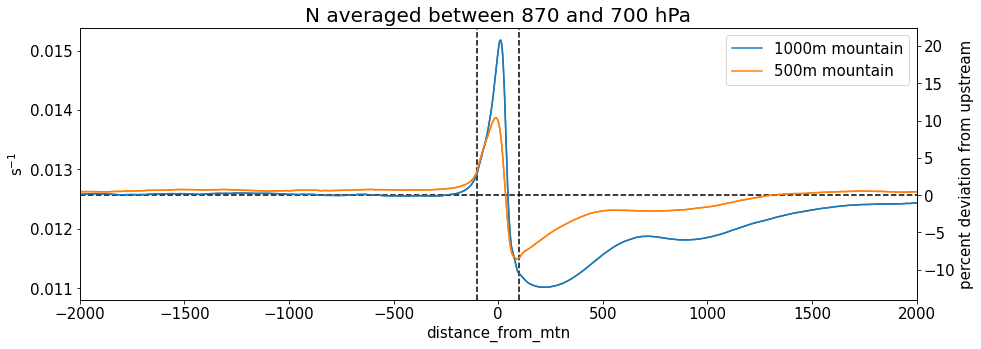

In [50]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax2=ax.twinx()

hrN_avg = pressure_avg(hrN,870,700)
lmN_avg = pressure_avg(lmN,870,700)
upstream_avg=pressure_avg(hrN,870,700).sel(distance_from_mtn=slice(-2000,-3000)).mean()
hrN_avg.plot(ax=ax,label='1000m mountain')
lmN_avg.plot(ax=ax,label='500m mountain')
((hrN_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain')
((lmN_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain')

ax.set_xlim(-2000,2000)
ax.axhline(upstream_avg,color='k',linestyle='--')
ax.axvline(-100.,color='k',linestyle='--')
ax.axvline(100.,color='k',linestyle='--')
ax.set_ylabel("s$^{-1}$")
ax2.set_ylabel("percent deviation from upstream")
ax.legend()
ax.set_title(r"N averaged between 870 and 700 hPa",fontsize=20.)

## dq/dz

In [26]:
qmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc'),staggered=False)
lmqmean_s = change_coords_eta(hrchannel500_11_ini,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc'),staggered=False)
qmean_sz=interp_eta_to_z(hrchannel,qmean_s,staggered=0)
lmqmean_sz=interp_eta_to_z(hrchannel500_11_ini,lmqmean_s,staggered=0)

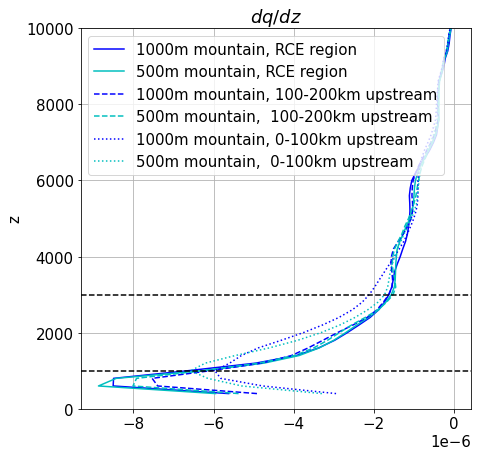

In [237]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
qmean_sz.differentiate('z').sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn').plot(ax=ax,y='z',color='b',label='1000m mountain, RCE region')
lmqmean_sz.differentiate('z').sel(distance_from_mtn=slice(-2000,-3000)).mean('distance_from_mtn').plot(ax=ax,y='z',color='c',label='500m mountain, RCE region')

qmean_sz.differentiate(  'z').sel(distance_from_mtn=slice(-100,-200)).mean('distance_from_mtn').plot(ax=ax,y='z',color='b',linestyle='--',label='1000m mountain, 100-200km upstream')
lmqmean_sz.differentiate('z').sel(distance_from_mtn=slice(-100,-200)).mean('distance_from_mtn').plot(ax=ax,y='z',color='c',linestyle='--',label='500m mountain,  100-200km upstream')

qmean_sz.differentiate(  'z').sel(distance_from_mtn=slice(0,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',color='b',linestyle=':',label='1000m mountain, 0-100km upstream')
lmqmean_sz.differentiate('z').sel(distance_from_mtn=slice(0,-100)).mean('distance_from_mtn').plot(ax=ax,y='z',color='c',linestyle=':',label='500m mountain,  0-100km upstream')


ax.axhline(1000.,color='k',linestyle='--')
ax.axhline(3000.,color='k',linestyle='--')
ax.set_ylim(0,10000)
ax.grid()
ax.set_title(r"$dq/dz$")
ax.legend()

Text(0.5, 1.0, '$|dq/dz|$ averaged between 1000m and 3000m')

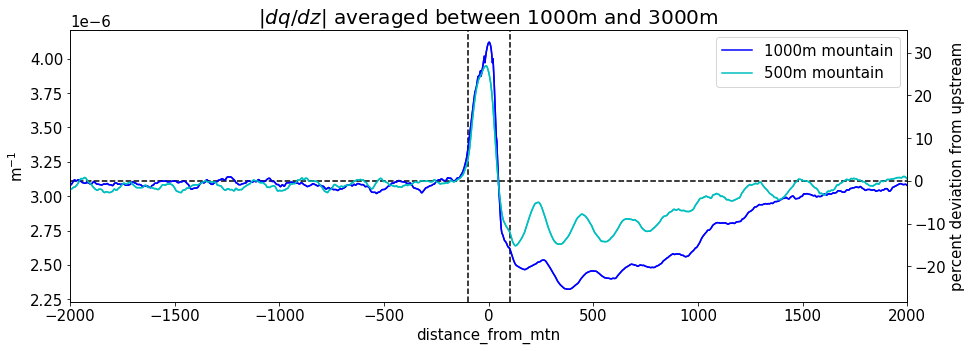

In [245]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax2=ax.twinx()

hrdqdz_avg = qmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
lmdqdz_avg = lmqmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
upstream_avg=hrdqdz_avg.sel(distance_from_mtn=slice(-2000,-3000)).mean()
(-hrdqdz_avg).plot(ax=ax,label='1000m mountain',color='b')
(-lmdqdz_avg).plot(ax=ax,label='500m mountain' ,color='c')
((hrdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain',color='b')
((lmdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain' ,color='c')

ax.set_xlim(-2000,2000)
ax.axhline(-upstream_avg,color='k',linestyle='--')
ax.axvline(-100.,color='k',linestyle='--')
ax.axvline(100.,color='k',linestyle='--')
ax.set_ylabel("m$^{-1}$")
ax2.set_ylabel("percent deviation from upstream")
ax.legend()
ax.set_title(r"$|dq/dz|$ averaged between 1000m and 3000m",fontsize=20.)

In [1]:
8.1/2.5e6

3.24e-06

## Figure for reviewer 1

In [28]:
qmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc'),staggered=False)
lmqmean_s = change_coords_eta(hrchannel500_11_ini,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc'),staggered=False)
qmean_sz=interp_eta_to_z(hrchannel,qmean_s,staggered=0)
lmqmean_sz=interp_eta_to_z(hrchannel500_11_ini,lmqmean_s,staggered=0)

In [51]:
tmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc'),staggered=False)
lmtmean_s = change_coords_eta(hrchannel500_11_ini,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc'),staggered=False)
tmean_sz=interp_eta_to_z(hrchannel,tmean_s,staggered=0)
lmtmean_sz=interp_eta_to_z(hrchannel500_11_ini,lmtmean_s,staggered=0)

In [73]:
g=9.81
cp=1004.
hrN_sz = np.sqrt(g/tmean_sz*(tmean_sz.differentiate('z')+g/cp))
lmN_sz = np.sqrt(g/lmtmean_sz*(lmtmean_sz.differentiate('z')+g/cp))

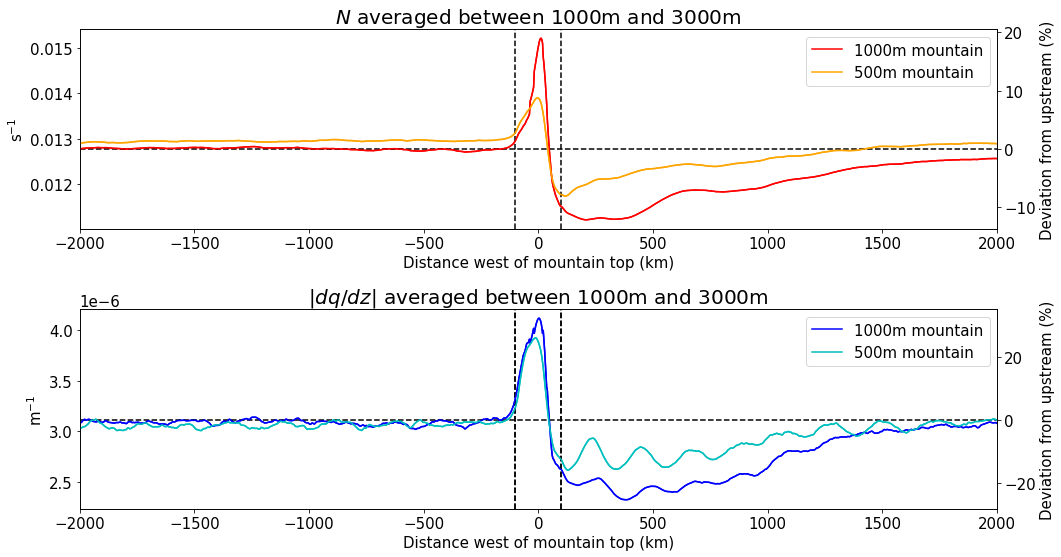

In [74]:
matplotlib.rcParams.update({'font.size': 15})
fig,axs = plt.subplots(2,1,figsize=(15,8))

ax=axs[0]
ax2=ax.twinx()
hrN_avg = hrN_sz.sel(z=slice(1000,3000)).mean('z')
lmN_avg = lmN_sz.sel(z=slice(1000,3000)).mean('z')
upstream_avg=hrN_avg.sel(distance_from_mtn=slice(-2000,-3000)).mean()

(hrN_avg).plot(ax=ax,label='1000m mountain',color='r')
(lmN_avg).plot(ax=ax,label='500m mountain' ,color='orange')
((hrN_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain',color='r')
((lmN_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain' ,color='orange')

ax.axhline(upstream_avg,color='k',linestyle='--')
ax.set_ylabel("s$^{-1}$")
ax2.set_ylabel("Deviation from upstream (%)")
ax.set_title(r"$N$ averaged between 1000m and 3000m",fontsize=20.)

ax=axs[1]
ax2=ax.twinx()

hrdqdz_avg = qmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
lmdqdz_avg = lmqmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
upstream_avg=hrdqdz_avg.sel(distance_from_mtn=slice(-2000,-3000)).mean()

(-hrdqdz_avg).plot(ax=ax,label='1000m mountain',color='b')
(-lmdqdz_avg).plot(ax=ax,label='500m mountain' ,color='c')
((hrdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain',color='b')
((lmdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain' ,color='c')

ax.axhline(-upstream_avg,color='k',linestyle='--')
ax.axvline(-100.,color='k',linestyle='--')
ax.axvline(100.,color='k',linestyle='--')
ax.set_ylabel("m$^{-1}$")
ax2.set_ylabel("Deviation from upstream (%)")

ax.set_title(r"$|dq/dz|$ averaged between 1000m and 3000m",fontsize=20.)

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.axvline(-100.,color='k',linestyle='--')
    ax.axvline(100.,color='k',linestyle='--')
    ax.legend()
    ax.set_xlabel("Distance west of mountain top (km)")

fig.tight_layout()

In [139]:
hrdsdz_sz = cp*tmean_sz.differentiate('z')+g
lmdsdz_sz = cp*lmtmean_sz.differentiate('z')+g

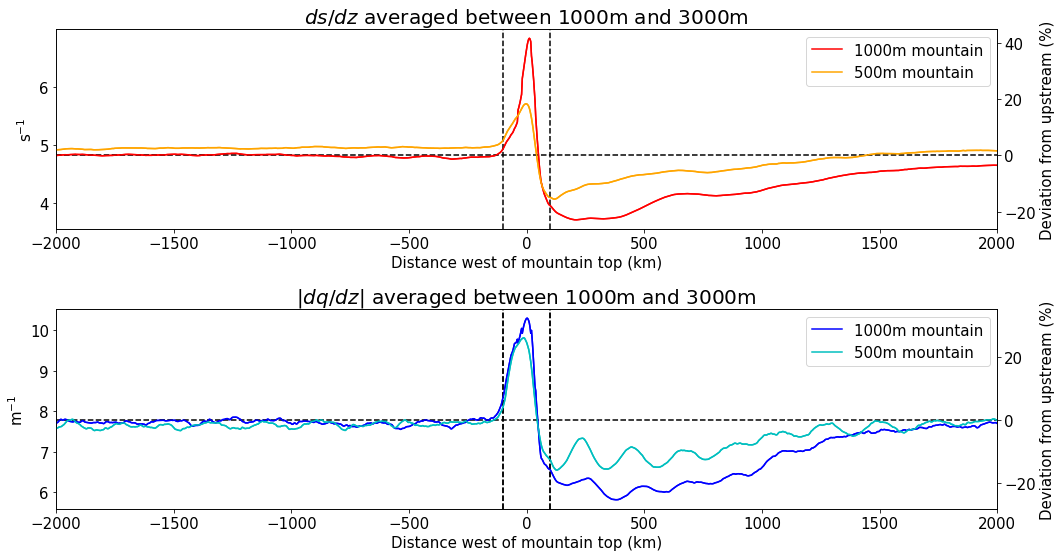

In [145]:
matplotlib.rcParams.update({'font.size': 15})
fig,axs = plt.subplots(2,1,figsize=(15,8))

ax=axs[0]
ax2=ax.twinx()
hrdsdz_avg = hrdsdz_sz.sel(z=slice(1000,3000)).mean('z')
lmdsdz_avg = lmdsdz_sz.sel(z=slice(1000,3000)).mean('z')
upstream_avg=hrdsdz_avg.sel(distance_from_mtn=slice(-2000,-3000)).mean()

(hrdsdz_avg).plot(ax=ax,label='1000m mountain',color='r')
(lmdsdz_avg).plot(ax=ax,label='500m mountain' ,color='orange')
((hrdsdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain',color='r')
((lmdsdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain' ,color='orange')

ax.axhline(upstream_avg,color='k',linestyle='--')
ax.set_ylabel("s$^{-1}$")
ax2.set_ylabel("Deviation from upstream (%)")
ax.set_title(r"$ds/dz$ averaged between 1000m and 3000m",fontsize=20.)

ax=axs[1]
ax2=ax.twinx()

hrdqdz_avg = 2.5e6*qmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
lmdqdz_avg = 2.5e6*lmqmean_sz.differentiate('z').sel(z=slice(1000,3000)).mean('z')
upstream_avg=hrdqdz_avg.sel(distance_from_mtn=slice(-2000,-3000)).mean()

(-hrdqdz_avg).plot(ax=ax,label='1000m mountain',color='b')
(-lmdqdz_avg).plot(ax=ax,label='500m mountain' ,color='c')
((hrdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='1000m mountain',color='b')
((lmdqdz_avg/upstream_avg-1)*100).plot(ax=ax2,label='500m mountain' ,color='c')

ax.axhline(-upstream_avg,color='k',linestyle='--')
ax.axvline(-100.,color='k',linestyle='--')
ax.axvline(100.,color='k',linestyle='--')
ax.set_ylabel("m$^{-1}$")
ax2.set_ylabel("Deviation from upstream (%)")

ax.set_title(r"$|dq/dz|$ averaged between 1000m and 3000m",fontsize=20.)

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.axvline(-100.,color='k',linestyle='--')
    ax.axvline(100.,color='k',linestyle='--')
    ax.legend()
    ax.set_xlabel("Distance west of mountain top (km)")

fig.tight_layout()

In [147]:
0.02*1.2*0.3*86400

622.0799999999999

# Tropopause & damping layer

In [278]:
# Tropopause
tmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')


In [28]:
%time PHB = (hrchannel.PHB[0,:,0,2000:3000]+hrchannel.PH[-100:,:,:,2000:3000]).mean(['Time','south_north','west_east']).load()/9.81

CPU times: user 2.25 s, sys: 10.1 s, total: 12.4 s
Wall time: 28.1 s


In [267]:
%time PB = (hrchannel.PB[0,:,0,2000:3000]+hrchannel.P[-100:,:,:,2000:3000]).mean(['Time','south_north','west_east']).load()/100.

CPU times: user 2.38 s, sys: 8.85 s, total: 11.2 s
Wall time: 22.8 s


In [261]:
PHB_destag = wrf.destagger(PHB,0)

(-0.1, 0.2)

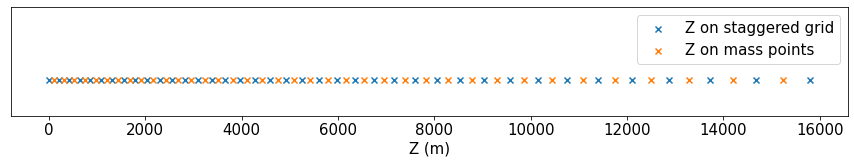

In [266]:
fig,ax = plt.subplots(1,1,figsize=(15,2))
ax.scatter(PHB       ,0*PHB       ,marker='x',label='Z on staggered grid')
ax.scatter(PHB_destag,0*PHB_destag,marker='x',label='Z on mass points')
ax.set_yticks([])
ax.set_xlabel("Z (m)")
ax.legend()
ax.set_ylim(-0.1,0.2)

In [279]:
tmean_s = tmean_s.assign_coords({'pressure':PB,'z':xr.DataArray(PHB_destag,dims='bottom_top')})

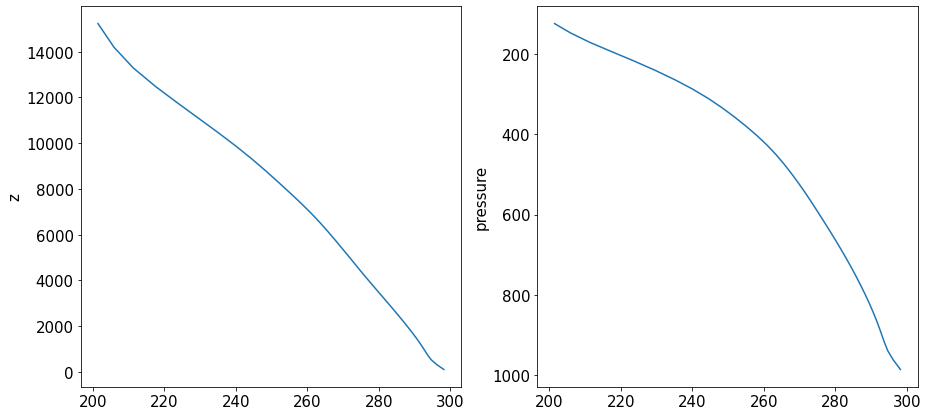

In [285]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
tmean_s[:,2000:3000].mean('west_east').plot(ax=axs[0],y='z')
tmean_s[:,2000:3000].mean('west_east').plot(ax=axs[1],y='pressure',yincrease=False)

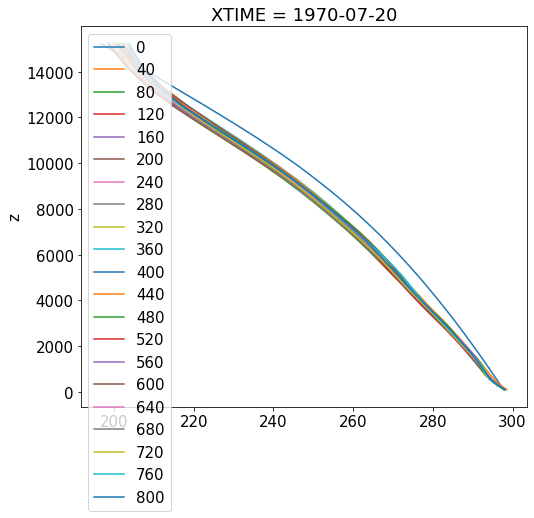

In [403]:
fig,ax = plt.subplots(1,1,figsize=(8,7))
temps=[]
for t in range(0,801,40):
    temp = ((hrchannel.T[t]+300)*((hrchannel.PB[t]+hrchannel.P[t])/1e5)**0.286).isel(west_east=slice(2000,3000)).mean(['south_north','west_east']).load()
    temps.append(list(temp))
    temp.assign_coords({'z':xr.DataArray(PHB_destag,dims='bottom_top')}).plot(ax=ax,y='z',label=t)
ax.legend()
temps = np.array(temps)
    

In [392]:
hrchannel500_11_300 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.3km/')
hrchannel500_11_302 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/')

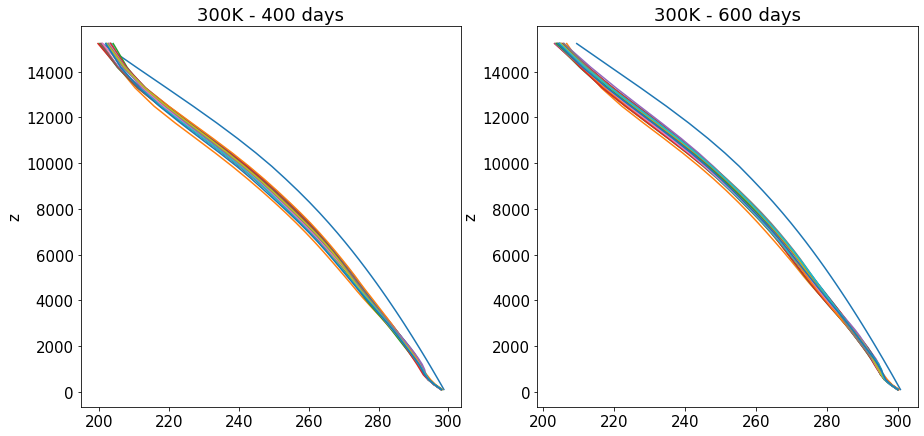

In [397]:
fig,axs = plt.subplots(1,2,figsize=(15,7))
temps_300=[]
temps_302=[]
for t in range(0,1601,80):
    temp = ((hrchannel500_11_300.T[t]+300)*((hrchannel500_11_300.PB[t]+hrchannel500_11_300.P[t])/1e5)**0.286).isel(west_east=slice(2000,3000)).mean(['south_north','west_east']).load()
    temps_300.append(list(temp))
    temp.assign_coords({'z':xr.DataArray(PHB_destag,dims='bottom_top')}).plot(ax=axs[0],y='z',label=t)
for t in range(0,2401,80):
    temp = ((hrchannel500_11_302.T[t]+300)*((hrchannel500_11_302.PB[t]+hrchannel500_11_302.P[t])/1e5)**0.286).isel(west_east=slice(2000,3000)).mean(['south_north','west_east']).load()
    temps_302.append(list(temp))
    temp.assign_coords({'z':xr.DataArray(PHB_destag,dims='bottom_top')}).plot(ax=axs[1],y='z',label=t)
axs[0].set_title('300K - 400 days')
axs[1].set_title('300K - 600 days')
temps_300 = np.array(temps_300)
temps_302 = np.array(temps_302)
    

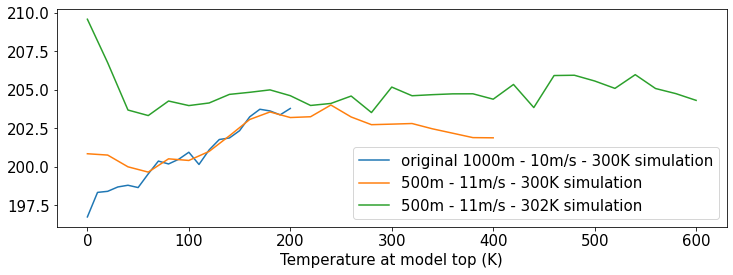

In [406]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(np.arange(0,201,10),temps[:,-1]    ,label='original 1000m - 10m/s - 300K simulation')
ax.plot(np.arange(0,401,20),temps_300[:,-1],label='500m - 11m/s - 300K simulation')
ax.plot(np.arange(0,601,20),temps_302[:,-1],label='500m - 11m/s - 302K simulation')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Temperature at model top (K)')
ax.legend()

# Ei$(x)e^{-x}$

In [288]:
from scipy.special import expi

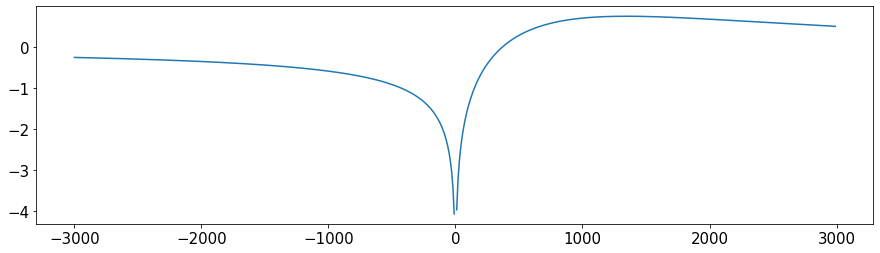

In [289]:
xx=np.arange(-3000,3000,10)
Lq=1000

fig,ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(xx,np.exp(-xx/Lq)*expi(xx/Lq))

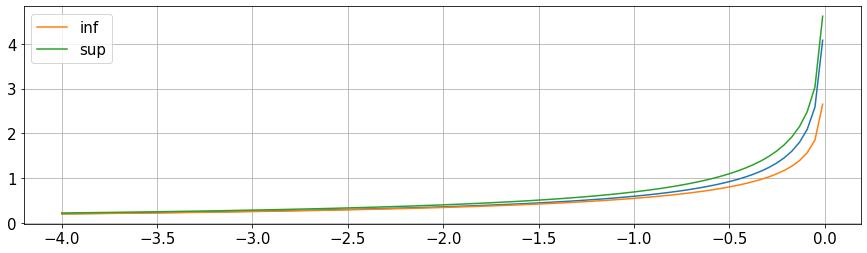

In [337]:
x=np.linspace(-4,-1e-2,100)

fig,ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(x,-expi(x)*np.exp(-x))
#fx=0
#fact=1
#for n in range(5):
#    fact=max(1,fact*n)
#    fx+=fact/(-x)**n
#    ax.plot(x,-np.exp(x)/x*fx,label=n)

ax.plot(x,0.5*np.log(1-2/x),label='inf')
ax.plot(x,np.log(1-1/x),label='sup')


ax.grid()
#ax.set_ylim(-4,4)
#ax.set_yscale('log')
ax.legend()

In [374]:
U=10
tauT=3*3600
tauq=11*3600
pT_ov_g = 8e3 #mass of troposphere in kg/m2
ds0dz,dq0dz,N = lapse_rates()
chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lc * 86400
zbot=1000
ztop=3000
l=N/U
cosfact=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)
sinfact=(np.sin(l*ztop)-np.sin(l*zbot))/(l*ztop-l*zbot)
Lq=compute_Lq(5,10,tauq)

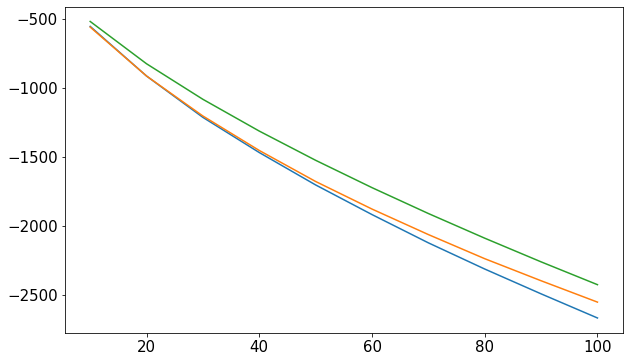

In [375]:
xu_full = []
xu_an   = []
a_s=np.arange(10e3,101e3,10e3)
for a in a_s:
    x,hx = topographic_profile(kind='agnesi',a=a,A=1000)
    P1000 = linear_precip_theory(x,hx,10)
    _,P1000a = analytical_precip_agnesi(10,a=a,A=1000)
    xu_full.append(x[np.argmax(P1000-4>1)] )
    xu_an  .append(x[np.argmax(P1000a-4>1)])
matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(a_s/1e3,np.array(xu_full)/1e3)
ax.plot(a_s/1e3,np.array(xu_an  )/1e3)
ax.plot(a_s/1e3,-Lq**0.33*(chi*cosfact*a_s*1000/3)**0.67/1e3)

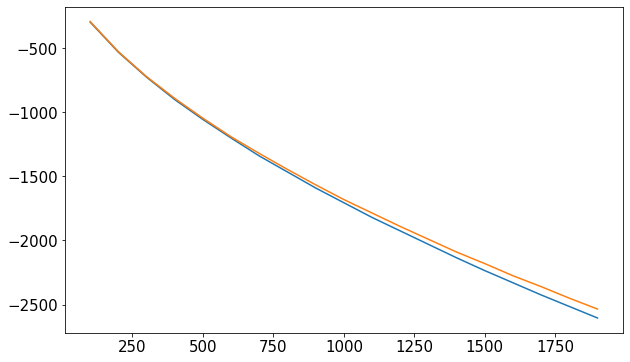

In [303]:
xu_full = []
xu_an   = []
A_s=np.arange(100,2000,100)
for A in A_s:
    x,hx = topographic_profile(kind='agnesi',a=50e3,A=A)
    P1000 = linear_precip_theory(x,hx,10)
    _,P1000a = analytical_precip_agnesi(10,a=50e3,A=A)
    xu_full.append (x[np.argmax(P1000-4>1)] )
    xu_an  .append (x[np.argmax(P1000a-4>1)])
matplotlib.rcParams.update({'font.size': 15})
_,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(A_s,np.array(xu_full)/1e3)
ax.plot(A_s,np.array(xu_an  )/1e3)

In [345]:
def analytical_precip_agnesi2(U,a=100e3,A=1000,tauT=3,tauq=11,P0 = 4.,switch=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    xx=np.arange(-10000e3,20000e3,5e3)
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lc * 86400
    
    zbot=1000
    ztop=3000
    l=N/U
    cosfact=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)
    sinfact=(np.sin(l*ztop)-np.sin(l*zbot))/(l*ztop-l*zbot)

    P = P0 + chi * cosfact * A*a *(-1/xx-switch*1/Lq*np.log(1-Lq/xx))
    P = np.maximum(0.,P)
    return xx,P


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


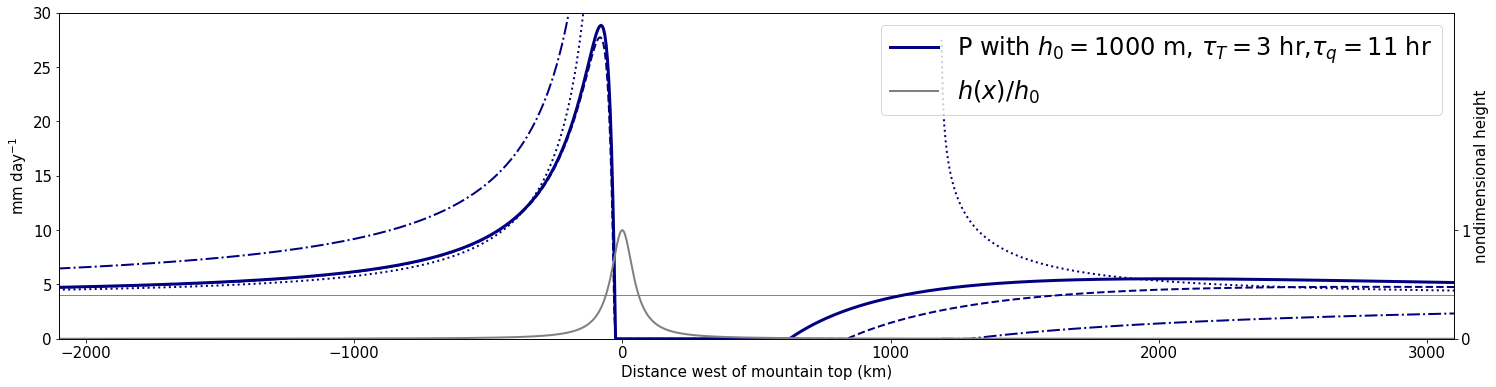

In [346]:
x,hx = topographic_profile(kind='agnesi',a=50e3,A=1000)
P1000 = linear_precip_theory(x,hx,10)
_,P1000a = analytical_precip_agnesi(10,a=50e3,A=1000)
_,P1000a2 = analytical_precip_agnesi2(10,a=50e3,A=1000)
_,P1000a3 = analytical_precip_agnesi2(10,a=50e3,A=1000,switch=1e-4)


x/=1000

fig,ax=plt.subplots(1,1,figsize=(25,6))
ax2=ax.twinx()

# precips
ax.plot(x,P1000,label=r"P with $h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr",color='navy',linewidth=3)
ax.plot(x,P1000a,linestyle='--',color='navy',linewidth=2)
ax.plot(x,P1000a2,linestyle=':',color='navy',linewidth=2)
ax.plot(x,P1000a3,linestyle='-.',color='navy',linewidth=2)

# mountain
ax2.plot(x,hx/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)
#ax2.plot(x,hx1/1000,label=r"$h(x)/h_0$",color='k',linewidth=3)
#ax2.plot(x,hx2/1000,label=r"$h(x)/h_0$",color='k',linewidth=3)


ax.axhline(4.,linewidth=0.5,color='navy')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,3.1e3)
ax.set_ylim(0,30)

ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,3)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)

(-2.0, 1.0)

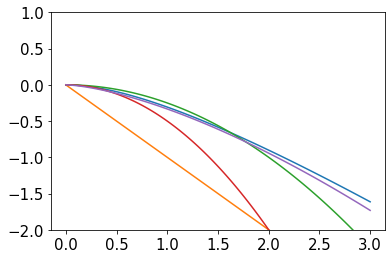

In [377]:
x = np.linspace(0.,3,100)
plt.plot(x,np.log(1+x)-x)
plt.plot(x,-x)
plt.plot(x,-x**2/4)
plt.plot(x,-x**2/2)
plt.plot(x,-x**1.5/3)
plt.ylim(-2,1)


# Creating an input sounding from a RCE run

In [77]:
import wrf
def ztq(wrfinput,wrfrun):
    pressure =(wrfinput.PB[0,:,0,0]+wrfrun.P[-40:].mean(['Time','south_north','west_east']))
    z_stag = (wrfinput.PHB[0,:,0,0]+wrfrun.PH[-40:].mean(['Time','south_north','west_east']))/9.81
    z_destag = wrf.destagger(z_stag,0)
    theta = 300+wrfrun.T.mean(['south_north','west_east'])
    q = wrfrun.QVAPOR.mean(['south_north','west_east']).load()
    temp = (theta*(pressure/1e5)**0.286).load()
    
    return z_destag,temp,q

In [5]:
rceinput = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km/wrfinput_d01")
rcerun = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km/")  

In [6]:
z_rce,temp_rce,q_rce = ztq(rceinput,rcerun)

In [79]:
%%time
z_stag_ref = (hrchannel.PHB[0,:,0,0]+hrchannel.PH[-40:].mean(['Time','south_north','west_east']))/9.81
z_ref  = wrf.destagger(z_stag_ref,0)
temp_ref = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc").mean(['west_east'])
q_ref = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc").mean(['west_east'])


CPU times: user 1.67 s, sys: 3.12 s, total: 4.79 s
Wall time: 8.1 s


Text(0.5, 0, 'T (K)')

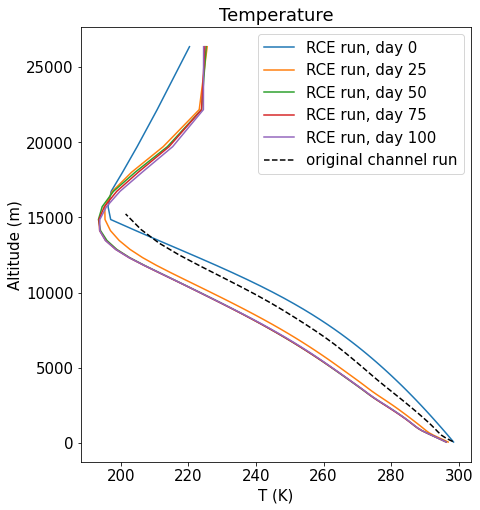

In [96]:
matplotlib.rcParams.update({'font.size':15})
fig,ax=plt.subplots(1,1,figsize=(7,8))
for i in range(0,401,100):
    ax.plot(temp_rce[i],z_rce,label="RCE run, day %i"%(i//4))
ax.plot(temp_ref,z_ref,color='k',linestyle='--',label="original channel run")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Temperature');ax.set_xlabel('T (K)')


Text(0.5, 0, 'Q (g/kg)')

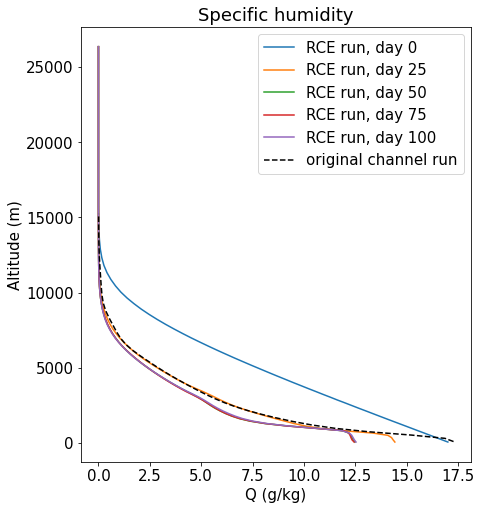

In [101]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
for i in range(0,401,100):
    ax.plot(1e3*q_rce[i],z_rce,label="RCE run, day %i"%(i//4))
ax.plot(1e3*q_ref,z_ref,color='k',linestyle='--',label="original channel run")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Specific humidity');ax.set_xlabel('Q (g/kg)')

# RCE run with background wind

In [10]:
rceinput2 = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km.2/wrfinput_d01")
rcerun2 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km.2/")  

In [11]:
z_rce2,temp_rce2,q_rce2 = ztq(rceinput2,rcerun2)

In [12]:
rceinput3 = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km.3/wrfinput_d01")
rcerun3 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/rce.wrf.2x2.3km.3/")
z_rce3,temp_rce3,q_rce3 = ztq(rceinput3,rcerun3)

In [13]:
def ztqinput(wrfinput):
    pressure =(wrfinput.PB[0,:,0,0]+wrfinput.P.mean(['Time','south_north','west_east']))
    z_stag = (wrfinput.PHB[0,:,0,0]+wrfinput.PH.mean(['Time','south_north','west_east']))/9.81
    z_destag = wrf.destagger(z_stag,0)
    theta = 300+wrfinput.T[0].mean(['south_north','west_east'])
    q = wrfinput.QVAPOR[0].mean(['south_north','west_east']).load()
    temp = (theta*(pressure/1e5)**0.286).load()
    return z_destag,temp,q
z_rce3in,temp_rce3in,_= ztqinput(rceinput3)

Text(0.5, 0, 'T (K)')

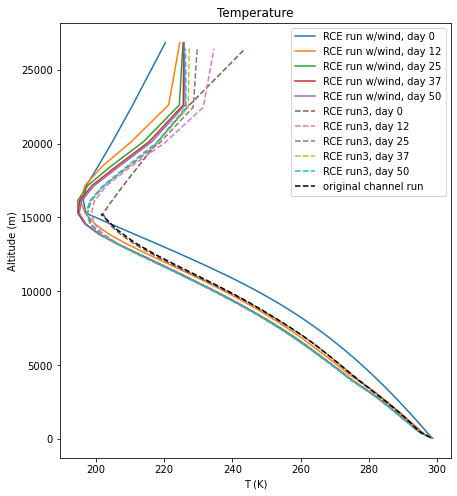

In [14]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
for i in range(0,201,50):
    ax.plot(temp_rce2[i],z_rce2,label="RCE run w/wind, day %i"%(i//4))
for i in range(0,201,50):
    ax.plot(temp_rce3[i],z_rce3,linestyle='--',label="RCE run3, day %i"%(i//4))
ax.plot(temp_ref,z_ref,color='k',linestyle='--',label="original channel run")
#ax.plot(temp_rce3in,z_rce3in,color='r',linestyle=':',label="original channel run")

ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Temperature');ax.set_xlabel('T (K)')


Text(0.5, 0, 'T (K)')

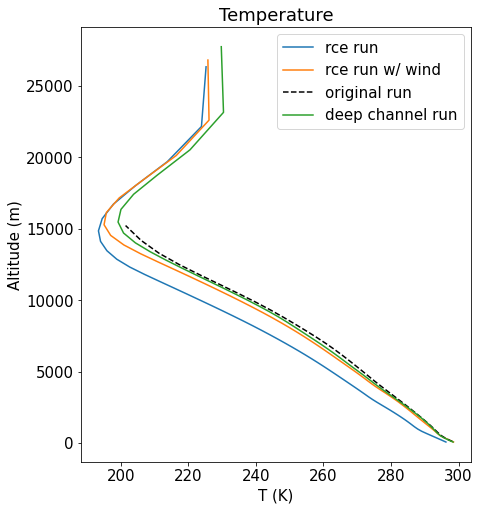

In [105]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
ax.plot(temp_rce[200],z_rce,label="rce run")
ax.plot(temp_rce2[200],z_rce2,label="rce run w/ wind")
ax.plot(temp_ref,z_ref,color='k',linestyle='--',label="original run")
ax.plot(temp_deep[200],z_deep,label="deep channel run")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Temperature');ax.set_xlabel('T (K)')

Text(0.5, 0, 'Q (g/kg)')

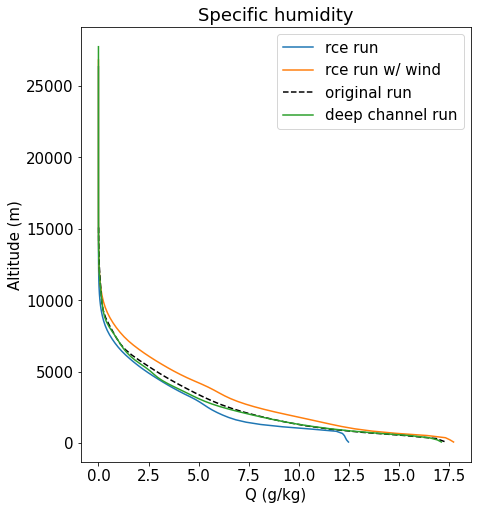

In [106]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
ax.plot(1e3*q_rce[200],z_rce,label="rce run")
ax.plot(1e3*q_rce2[200],z_rce2,label="rce run w/ wind")
ax.plot(1e3*q_ref,z_ref,color='k',linestyle='--',label="original run")
ax.plot(1e3*q_deep[200],z_deep,label="deep channel run")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Specific humidity');ax.set_xlabel('Q (g/kg)')

Text(0, 0.5, 'Altitude (m)')

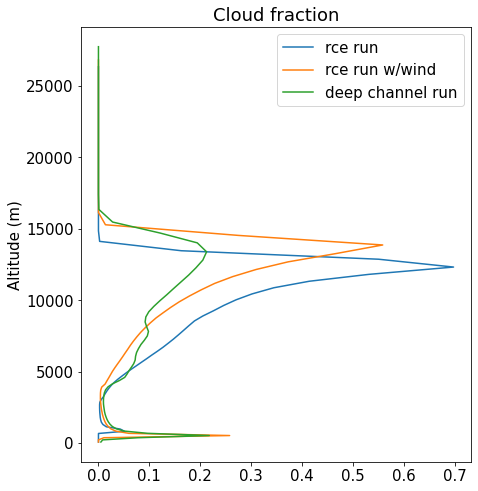

In [110]:
#rcecld = rcerun.CLDFRA[160:200].mean(['Time','south_north','west_east'])
#rcecld2 = rcerun2.CLDFRA[160:200].mean(['Time','south_north','west_east'])
#deepcld = deeprun.CLDFRA[160:200].mean(['Time','south_north','west_east'])

fig,ax=plt.subplots(1,1,figsize=(7,8))
ax.plot(rcecld,z_destag_rce,label="rce run")
ax.plot(rcecld2,z_destag_rce2,label="rce run w/wind")
ax.plot(deepcld,z_destag,label="deep channel run")
ax.legend(); ax.set_title('Cloud fraction');ax.set_ylabel('Altitude (m)')

In [204]:
rcerc = rcerun.RTHRATEN[160:200].mean(['Time','south_north','west_east']).load()
rce2rc = rcerun2.RTHRATEN[160:200].mean(['Time','south_north','west_east']).load()
deeprc = deeprun.RTHRATEN[160:200].mean(['Time','south_north','west_east']).load()

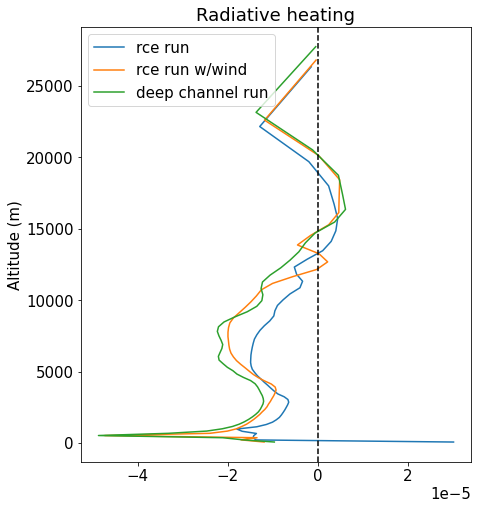

In [206]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
ax.plot(rcerc,z_destag_rce,label="rce run")
ax.plot(rce2rc,z_destag_rce2,label="rce run w/wind")
ax.plot(deeprc,z_destag,label="deep channel run")
ax.legend(); ax.set_title('Radiative heating');ax.set_ylabel('Altitude (m)')
ax.axvline(0.,linestyle='--',color='k')

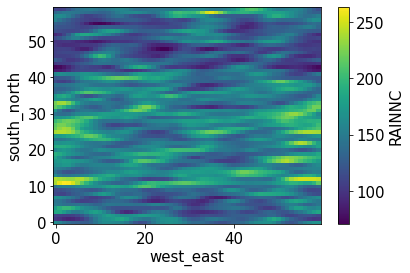

In [111]:
rcerun2.RAINNC[-40:].mean('Time').plot()

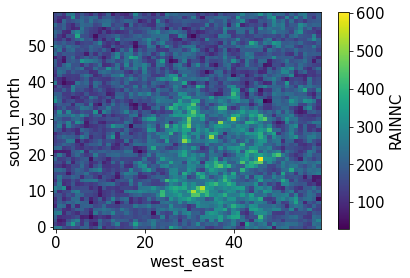

In [112]:
rcerun.RAINNC[-40:].mean('Time').plot()

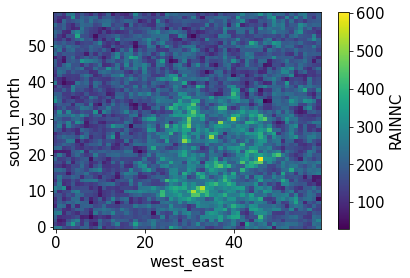

In [112]:
rcerun.RAINNC[-40:].mean('Time').plot()

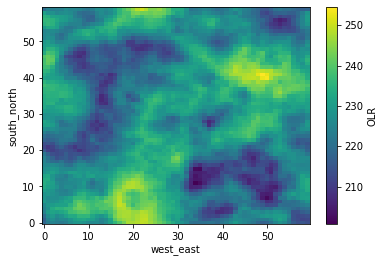

In [18]:
rcerun.OLR[-40:].mean(['Time']).plot()

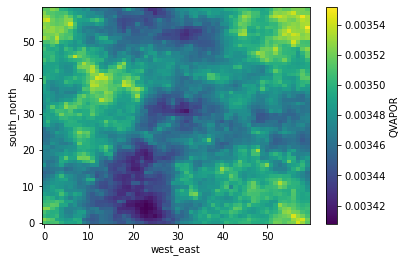

In [19]:
rcerun.QVAPOR[-40:].mean(['Time','bottom_top']).plot()

# Deep channel run

In [75]:
deepinput = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01")
deeprun = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/")  

In [78]:
%time z_deep,temp_deep,q_deep = ztq(deepinput,deeprun)

CPU times: user 52.1 s, sys: 2min 19s, total: 3min 11s
Wall time: 2min 31s


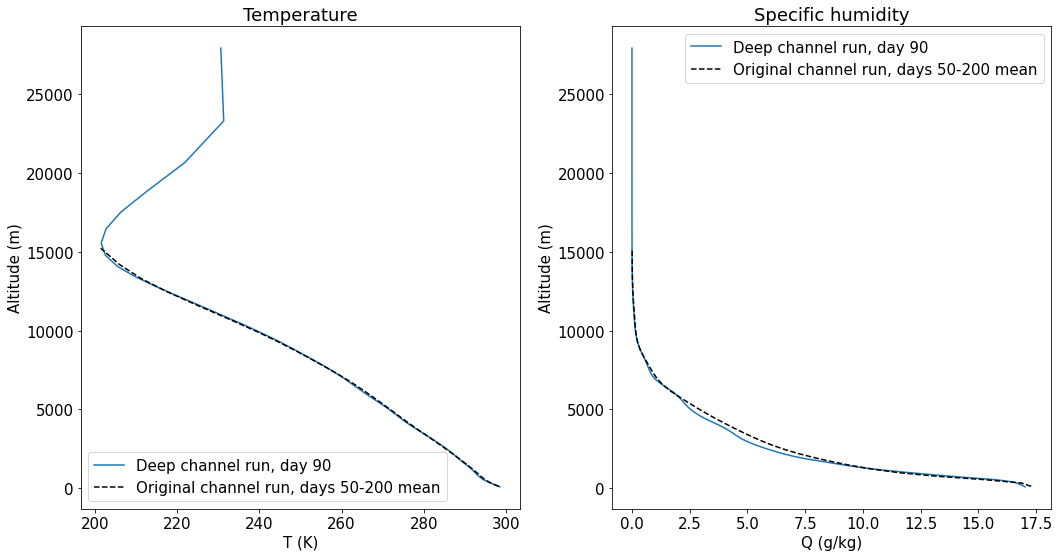

In [119]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
ax=axs[0]
ax.plot(temp_deep[365],z_deep,label="Deep channel run, day 90")
ax.plot(temp_ref,z_ref,color='k',linestyle='--',label="Original channel run, days 50-200 mean")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Temperature');ax.set_xlabel('T (K)')

ax=axs[1]
ax.plot(1e3*q_deep[365],z_deep,label="Deep channel run, day 90")
ax.plot(1e3*q_ref,z_ref,color='k',linestyle='--',label="Original channel run, days 50-200 mean")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Specific humidity');ax.set_xlabel('Q (g/kg)')
#ax.set_xscale('log')

fig.tight_layout()

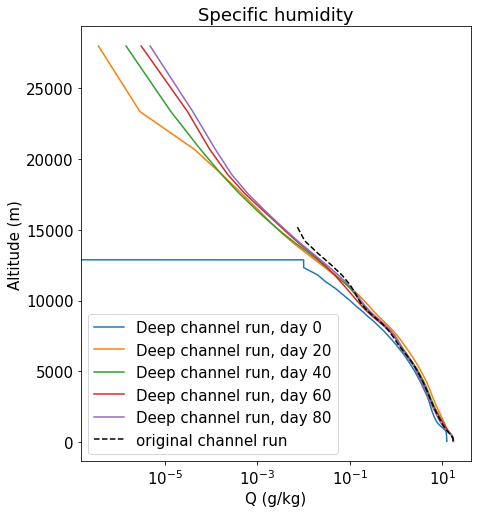

In [85]:
fig,ax=plt.subplots(1,1,figsize=(7,8))
for i in range(0,366,80):
    ax.plot(1e3*q_deep[i],z_deep,label="Deep channel run, day %i"%(i//4))
ax.plot(1e3*q_ref,z_ref,color='k',linestyle='--',label="original channel run")
ax.legend();ax.set_ylabel('Altitude (m)')
ax.set_title('Specific humidity');ax.set_xlabel('Q (g/kg)')
ax.set_xscale('log')

In [106]:
deeprunprecip=(deeprun.RAINNC[365]-deeprun.RAINNC[200]).mean('south_north').load()/(166/4)
hrchannelprecip_4050=(hrchannel.RAINNC[365]-hrchannel.RAINNC[200]).mean('south_north').load()/(166/4)

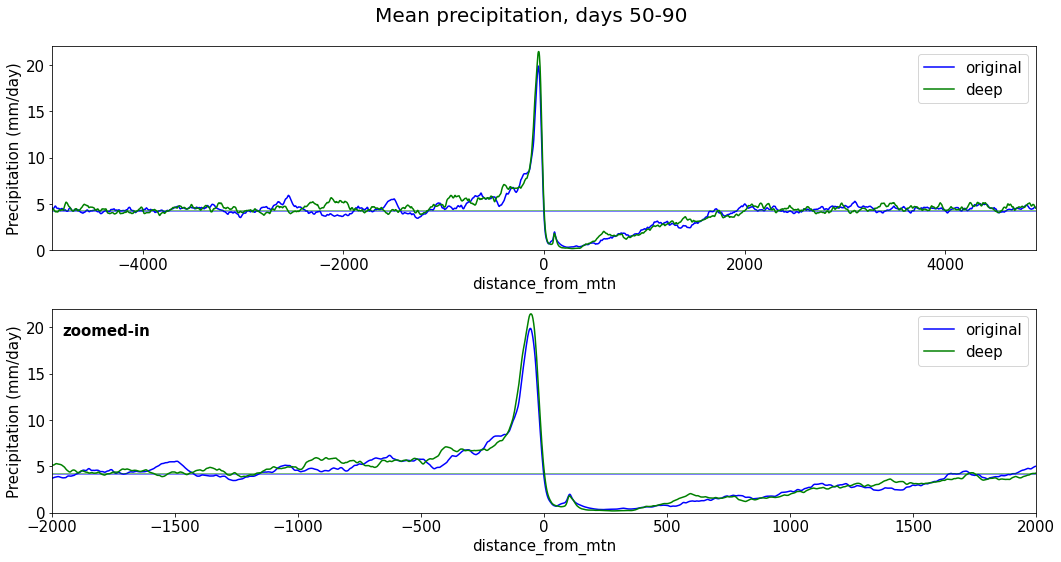

In [115]:
matplotlib.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(2,1,figsize=(15,8))
for ax in axs:
    change_coords_sfc(hrchannelprecip_4050).plot(ax=ax,color='b',label='original')
    ax.axhline(hrchannelprecip_4050.mean(),color='b',linewidth=0.5)
    change_coords_sfc(deeprunprecip).plot(ax=ax,color='g',label='deep')
    ax.axhline(deeprunprecip.mean(),color='g',linewidth=0.5)
    ax.legend();ax.set_ylabel('Precipitation (mm/day)')
    ax.set_ylim(0,22)
axs[0].set_xlim(-4900,4900)
axs[1].set_xlim(-2000,2000)
axs[1].text(0.01, 0.87,'zoomed-in', transform=axs[1].transAxes,color='k',weight='bold')

fig.suptitle("Mean precipitation, days 50-90",fontsize=20)
fig.tight_layout()

In [89]:
wmean_orig = deeprun.W[200:].mean(['Time','south_north']).load()

In [94]:
deepwmean_s = change_coords_eta(deeprun,wmean_orig,staggered=True)
deepwmean_sz = interp_eta_to_z(deeprun,deepwmean_s,dsinput=deepinput,plevs=np.arange(25.,990.,20.))

In [91]:
wmean_p    = xr.open_dataarray("../../orographicConvectionTheory/data/wrf.100x2.mountain.3km.W.days50-200.mean.nc")     # control simulation

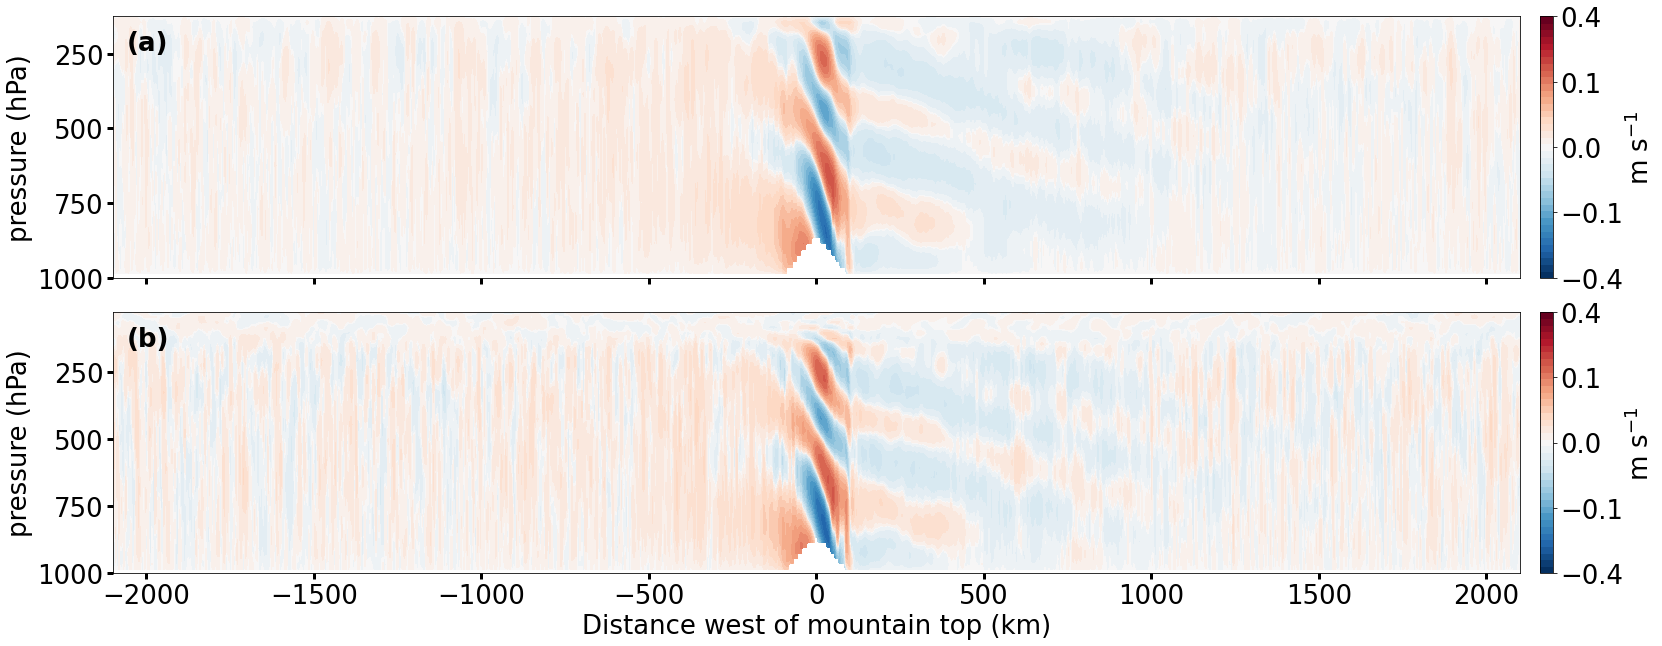

In [95]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

wmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
deepwmean_sp.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wxz.png', dpi=300 ,bbox_inches='tight')


In [97]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wmean_sz = interp_eta_to_z(hrchannel,wmean_s,zlevs= np.arange(0.,25000.,200.))
deepwmean_sz = interp_eta_to_z(deeprun,deepwmean_s,dsinput=deepinput,zlevs= np.arange(0.,25000.,200.))

In [120]:
PHB_deep = np.array(deepinput.PHB[0,:,0]+deeprun.PH[-100:].mean(['Time','south_north']))/9.81

In [127]:
PHB_shallow = np.array(hrchannel.PHB[0,:,0]+hrchannel.PH[-100:].mean(['Time','south_north']))/9.81

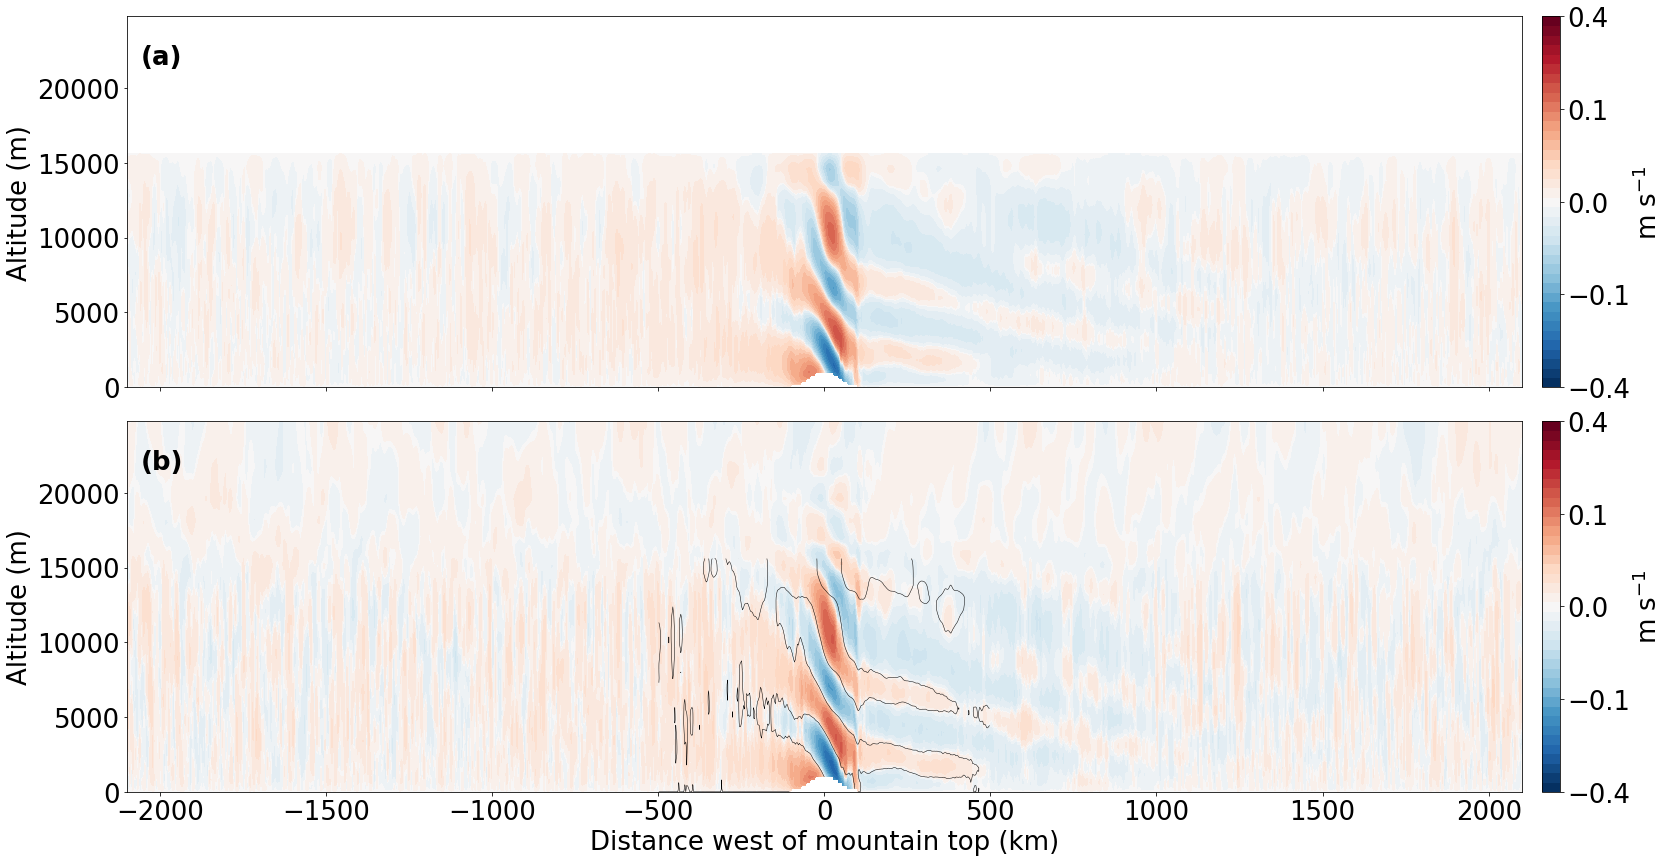

In [125]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,12))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

wmean_sz.plot.contourf(ax=ax[0], levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
deepwmean_sz.plot.contourf(ax=ax[1], levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})
wmean_sz.sel(distance_from_mtn=slice(500,-500)).plot.contour(ax=ax[1], levels=[0.],colors=['k'],linewidths=[0.5])

for a in ax:
    a.set_ylabel("Altitude (m)")
    a.set_xlim(-2100,2100)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
#fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wxz.png', dpi=300 ,bbox_inches='tight')


# Smith Linear model

In [8]:
# The parameters we need for Smith's linear model are: gamma,gamma_m,Hw,Cw.
# Lapse rates depend on height, hence we plot them below:

tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
tmean   = tmean.where(tmean >100.)  
tmean_p = change_coords_pl(hrchannel_p,tmean)[1:-4]

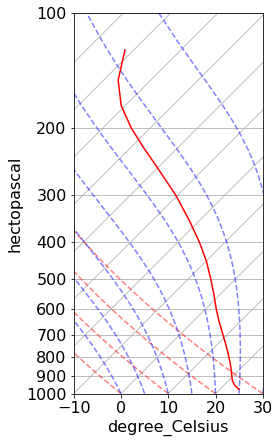

In [31]:
from orographicPrecipitation.precip_extremes_scaling import moist_adiabatic_lapse_rate
def plot_skewt_T(T):
    P = np.array(T.pressure)* units.hPa
    Tups = units.degK*np.array(T)

    fig = plt.figure(figsize=(10,7))
    skew = SkewT(fig, rotation=45)
    skew.plot(P, Tups,color='r' ,label="T - 200 to 400 km upstream")

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-10, 30)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
plot_skewt_T(tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'))

Surface to 900 hPa : Gamma = 6.31 K/km , Gamma_m = 4.01 K/km
900 hPa to 700 hPa : Gamma = 4.97 K/km , Gamma_m = 4.32 K/km
Surface to 500 hPa : Gamma = 5.45 K/km , Gamma_m = 4.32 K/km


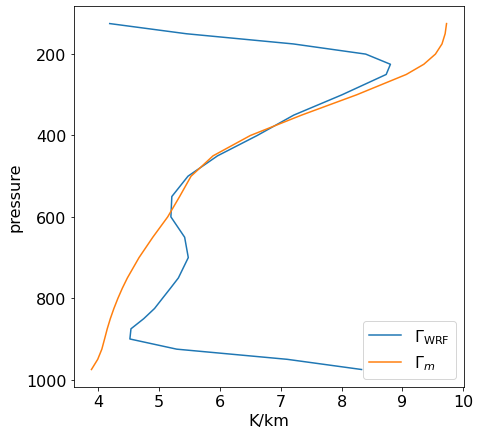

In [55]:
def lapserates(T):
    dTdp = T.differentiate('pressure')/100
    rho = T.pressure*100/287./T
    Gamma = 1000.*rho*9.81*dTdp
    
    Gamma_m = 1000.*moist_adiabatic_lapse_rate(np.array(T),100.*np.array(T.pressure),'era')
    Gamma_m = xr.DataArray(Gamma_m,coords={'pressure':T.pressure},dims={'pressure'})
    
    return Gamma,Gamma_m

def plot_lapserates(T):
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    Gamma,Gamma_m=lapserates(T)
    Gamma.plot(ax=ax,y='pressure',yincrease=False,label=r'$\Gamma_{\mathrm{WRF}}$')
    Gamma_m.plot(ax=ax,y='pressure',yincrease=False,label=r'$\Gamma_m$')
    
    print(r"Surface to 900 hPa : Gamma = %.2f K/km , Gamma_m = %.2f K/km"%(Gamma.sel(pressure=slice(1000.,899.)).mean('pressure'),Gamma_m.sel(pressure=slice(1000.,899.)).mean('pressure')))
    print(r"900 hPa to 700 hPa : Gamma = %.2f K/km , Gamma_m = %.2f K/km"%(Gamma.sel(pressure=slice(900.,699.)).mean('pressure'),Gamma_m.sel(pressure=slice(900.,699.)).mean('pressure')))
    print(r"Surface to 500 hPa : Gamma = %.2f K/km , Gamma_m = %.2f K/km"%(Gamma.sel(pressure=slice(1000.,499.)).mean('pressure'),Gamma_m.sel(pressure=slice(900.,699.)).mean('pressure')))

    ax.set_xlabel('K/km')
    ax.legend()
    
plot_lapserates(tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn'))

Computing $N^2$ from $-\dfrac{\rho g^2}{\theta}\dfrac{\partial \theta}{\partial p} \simeq \dfrac{g}{\theta}\dfrac{\partial \theta}{\partial z}$, vs the Fraser et al. version $\dfrac{g}{T}(\Gamma_d-\gamma)$

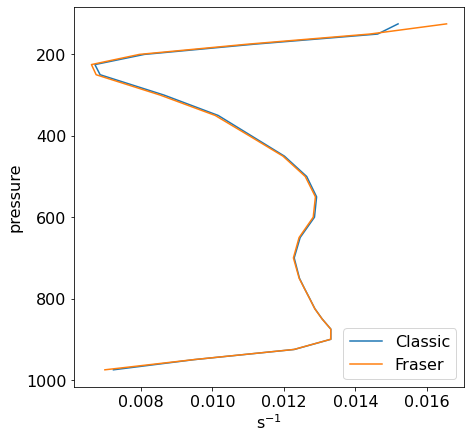

In [12]:
def compute_N(T,pfactor,pname='pressure'):
    """T in K, p in Pa and N in s"""
    g = 9.81; R=287.
    rho = pfactor*T[pname]/R/T
    theta = T*(pfactor*T[pname]/1e5)**(-0.287)
    return np.sqrt(-rho*g*g/theta*theta.differentiate(pname)/pfactor)
tmean_p_upstream = tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
N_wrf_1=compute_N(tmean_p_upstream,100)
Gamma,Gamma_m=lapserates(tmean_p_upstream)
N_wrf_2=np.sqrt(9.81/tmean_p_upstream*(9.81-Gamma)/1000) 

fig,ax = plt.subplots(1,1,figsize=(7,7))
N_wrf_1.plot(ax=ax,y='pressure',yincrease=False,label=r'Classic')
N_wrf_2.plot(ax=ax,y='pressure',yincrease=False,label=r'Fraser')
ax.set_xlabel(r's$^{-1}$')
ax.legend()

In [7]:
def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw

def smith_theory(u,gamma,gamma_m,ts=300.,tau=2000,kind='gaussian'):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f"%N)
    print("Hw=%i,Cw=%.3f"%(Hw,Cw))

    tau_c=tau
    tau_f=tau
    P0=4. #mm/day
    
    xx=np.arange(-10000e3,10000e3,1e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return xx,hx,P

def upslope_theory(u,gamma,gamma_m,ts=300.,kind='gaussian'):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    P0=4. #mm/day
    
    xx=np.arange(-10000e3,10000e3,1e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    k=k_vector(len(xx),xx[1]-xx[0])
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k)),0.)
    #P=np.maximum(P0+86400*Cw*u*np.gradient(hx,xx),0.) #np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return xx,hx,P

def k_vector(Nx,dx):
    return 2*np.pi*np.fft.fftfreq(Nx,dx)

def m_exponent(k,N,U):
    return - np.sign(k**2-N**2/U**2)**((np.sign(k+1e-4*k[1])+1)/2) * np.sqrt(k**2-N**2/U**2+0.j) #1e-4*k[1] it there to avoid fractional powers


using dry stability, N=0.012
Hw=3045,Cw=0.033
using dry stability, N=0.012
Hw=3045,Cw=0.033


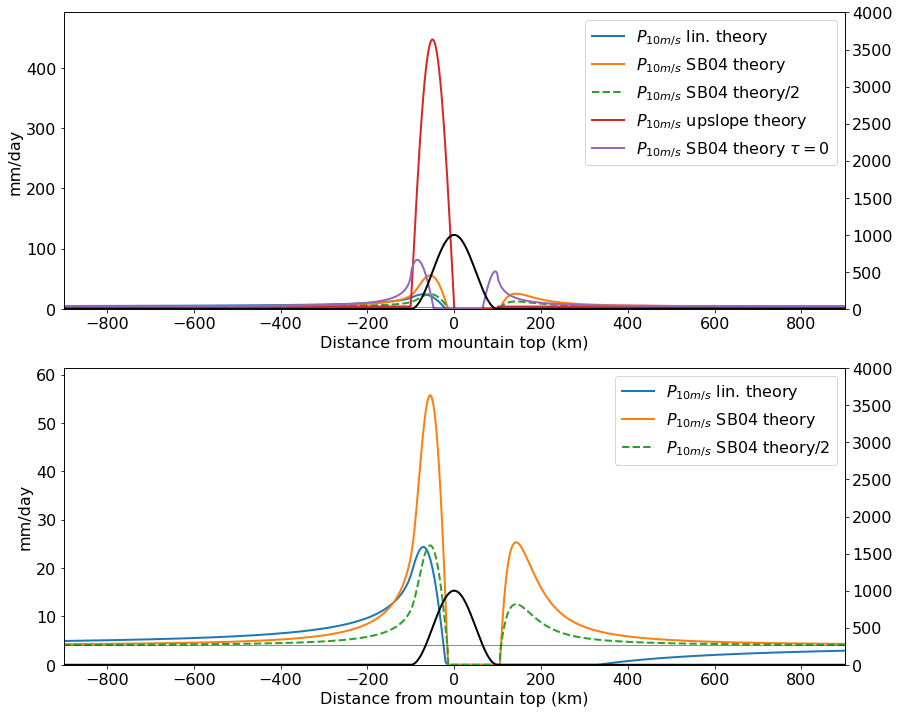

In [8]:
fig,axs=plt.subplots(2,1,figsize=(14,12))

lw=2
x,hx = topographic_profile(kind='cos')
Plin = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5,P0 = 4.)
xx,hx,Plin_smith = smith_theory(10,5.45e-3,4.32e-3,kind='cos')
xx,hx,Plin_smith2 = smith_theory(10,5.45e-3,4.32e-3,tau=0,kind='cos')
xx,hx,Plin_upslope = upslope_theory(10,5.45e-3,4.32e-3,kind='cos')
for i,ax in enumerate(axs):
    ax2=ax.twinx()
    ax.plot(x/1000,Plin,label = r"$P_{%i m/s}$ lin. theory"%10,linewidth=lw)
    ax.plot(xx/1000,Plin_smith,label = r"$P_{%i m/s}$ SB04 theory"%10,linewidth=lw)
    ax.plot(xx/1000,((Plin_smith-4)/2.5+4)*(Plin_smith>0),label = r"$P_{%i m/s}$ SB04 theory/2"%10,linestyle='--',linewidth=lw)
    ax.set_ylim(0,np.max(Plin_smith)*1.1)
    if i ==0:
        ax.plot(xx/1000,Plin_upslope,label = r"$P_{%i m/s}$ upslope theory"%10,linewidth=lw)
        ax.plot(xx/1000,Plin_smith2,label = r"$P_{%i m/s}$ SB04 theory $\tau=0$"%10,linewidth=lw)
        ax.set_ylim(0,np.max(Plin_upslope)*1.1)
    #else:
    #    ax.plot(xx/1000,4+(Plin_smith2-4)/(np.max(Plin_smith2)-4)*(np.max(Plin_smith)-4),label = r"$P_{%i m/s}$ SB04 theory $\tau=0$"%10,linewidth=lw)
    # mountain
    ax2.plot(xx/1000,hx,label=r"$h(x)$",color='k',linewidth=2)
    
    ax.axhline(4.,linestyle='-',linewidth=0.5,color='b')
    ax.set_xlabel('Distance from mountain top (km)')
    ax.set_ylabel('mm/day')
    ax.set_xlim(-900,900)
    ax2.set_ylim(0,4000)
    ax.legend()



using dry stability, N=0.012
Hw=3045
<xarray.DataArray ()>
array(0.00711498)
Coordinates:
    distance_from_mtn  float64 -80.0
<xarray.DataArray 'altitude' ()>
array(0.03213292)


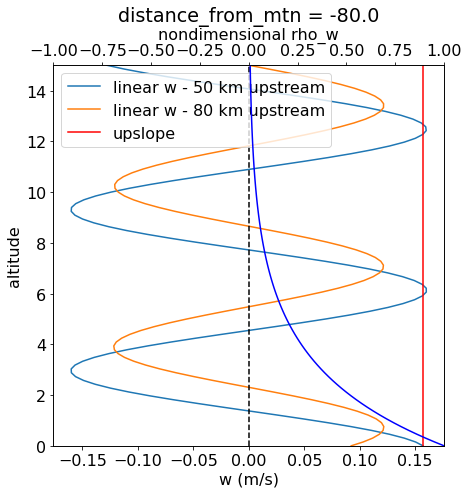

In [110]:
def plot_vertical_profiles(u,gamma,gamma_m,ts=300.):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f"%N)
    print("Hw=%i"%Hw)
    xx=np.arange(-10000e3,10000e3,1e3)
    A = 1000
    a = 100e3
    hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    w = linear_w(xx,hx,u)
    fig,ax=plt.subplots(1,1,figsize=(7,7))
    w.sel(distance_from_mtn=-50).plot(ax=ax,y='altitude',label='linear w - 50 km upstream')
    w.sel(distance_from_mtn=-80).plot(ax=ax,y='altitude',label='linear w - 80 km upstream')
    ax.axvline(u*np.gradient(hx,xx)[np.argmin((test+50e3)**2)],color='r',label='upslope')
    ax2=ax.twiny()
    np.exp(-w.altitude*1000/Hw).plot(ax=ax2,y='altitude',label='linear w',color='b')
    ax.legend()
    ax.set_ylim(0,15)
    ax.set_xlabel("w (m/s)")
    ax2.set_xlabel("nondimensional rho_w")
    ax2.set_xlim(-1,1)
    ax.axvline(0.,color='k',linestyle='--')
    print((w.sel(distance_from_mtn=-80)*np.exp(-w.altitude*1000/Hw)).mean())
    print((u*np.gradient(hx,xx)[np.argmin((test+50e3)**2)]*np.exp(-w.altitude*1000/Hw)).mean())
plot_vertical_profiles(10,5.45e-3,4.32e-3)

## Comparing upstream profiles from Smith vs our model

Fundamental difference between the two models: 
 - SBO4 is proportional to a weighted vertical mean $w$; $P' \simeq C_w \displaystyle\int_0^{\infty} w(x,z) e^{-z/H_w} \dfrac{\mathrm{d}z}{H_w}$
 - Our model is proportional to a lower-tropospheric mean displacement $\zeta$; $\dfrac{\mathrm{d}P'}{\mathrm{d}x} \simeq \chi \dfrac{w_{dL}(x)}{U}$ i.e. $P' \simeq \chi \zeta_L(x)$
 
Scales: 
 - $C_w \simeq 0.03$ kg/m$^3$ $\simeq 2500$ (mm/day)/(m/s), so constant $w = 0.1$ m/s gives $P'=250$ mm/day. Using a linear, sinusoidally-varying $w$ reduces this to about $50$ mm/day.
 - $\chi \simeq 0.05$ (mm/day)/m, so a uniform $1000$ m layer upward displacement gives $P'=50$ mm/day. Using a linear, sinusoidally-varying $w$ reduces this to about $20$ mm/day, depending on the wind.

using dry stability, N=0.012
Hw=3045,Cw=0.033


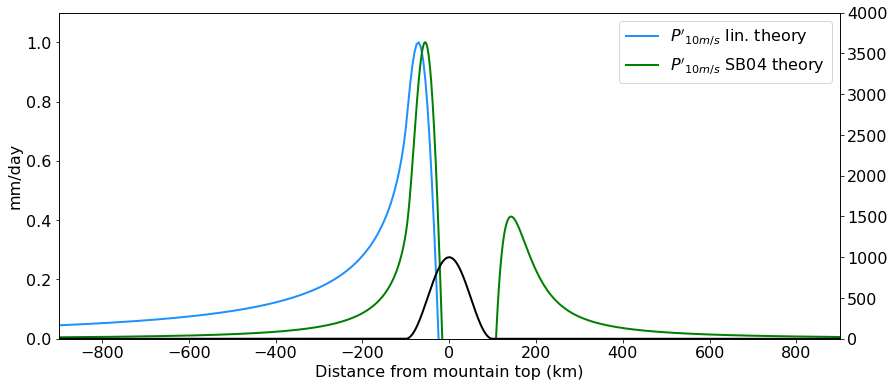

In [112]:
fig,ax=plt.subplots(1,1,figsize=(14,6))

lw=2
x,hx = topographic_profile(kind='cos')
Plin = linear_precip_theory(x,hx,10,tauT=7.5,tauq=27.5,P0 = 4.)
xx,hx,Plin_smith = smith_theory(10,5.45e-3,4.32e-3,kind='cos')
ax2=ax.twinx()
ax.plot(x/1000,(Plin-4)/np.max(Plin-4),label = r"$P'_{%i m/s}$ lin. theory"%10,linewidth=lw,color='dodgerblue')
ax.plot(xx/1000,(Plin_smith-4)/np.max(Plin_smith-4),label = r"$P'_{%i m/s}$ SB04 theory"%10,linewidth=lw,color='g')
# mountain
ax2.plot(xx/1000,hx,label=r"$h(x)$",color='k',linewidth=2)

ax.set_xlabel('Distance from mountain top (km)')
ax.set_ylabel('mm/day')
ax.set_xlim(-900,900)
ax.set_ylim(0,1.1)
ax2.set_ylim(0,4000)
ax.legend()


In [151]:
def compare_shapes(xx,hx,U):
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    N=0.01

    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    zeta_hat =  np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    w_hat = 1j*k*np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    w_hat2 = 1j*k*np.fft.fft(hx) /(1- m_exponent(k,N,U)*3e3)
    
    zeta = np.real(np.fft.ifft(zeta_hat))
    w = np.real(np.fft.ifft(w_hat))
    w2 = np.real(np.fft.ifft(w_hat2))
    return w/np.max(w[:2000]),zeta/np.max(zeta),w2/np.max(w2[:2000])


In [152]:
xx,hx = topographic_profile('cos')
w,zeta,w2 = compare_shapes(xx,hx,10)

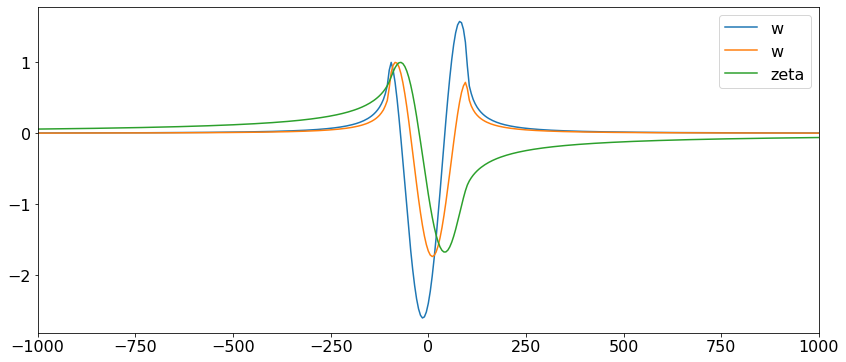

In [153]:
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.plot(xx/1000,w,label='w')
ax.plot(xx/1000,w2,label='w')
ax.plot(xx/1000,zeta,label='zeta')
ax.set_xlim(-1000,1000)
ax.legend()

In [88]:
wrfinput=xr.open_dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfinput_d01')

In [98]:
wrfinput.HGT

<xarray.DataArray 'HGT' (Time: 1, south_north: 66, west_east: 3270)>
[215820 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [6]:
hrchannel11_302 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.11mps.302K.3km/")

In [12]:
precip = (4*(hrchannel11_302.RAINNC[-1]-hrchannel11_302.RAINNC[200])/283).load().mean('south_north')

(1800.0, 1635.0)

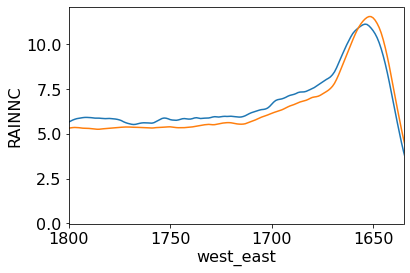

In [21]:
precip.plot()
hr500_11pr.plot()
plt.xlim(1800,1635)